# Global

## Concept

### One object to contain all data

The class `PV_DataContainer` is designed to produce one single object
(here `pvdc`) intended to contain all data to be used throughout the
analysis.

This enables to separate data analysis (implemented in this class) from
visualization (implemented in this Notebook).

The `pvdc` instance should hold all data that is used multiple times.

### Functions for individual sub figures


### Putting together figures with multiple panels/subplots

## Imports

In [1]:
# Standard library
import os
from collections import namedtuple

# 3rd party libraries
import numpy as np
import scipy as sp
import scipy.stats as stats; del stats # used as sp.stats
import pandas as pd

# ...matplotlib
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
#from matplotlib.legend_handler import HandlerTuple
# for figure_1a:
from mpl_toolkits.axes_grid1.inset_locator import InsetPosition

# plotting specific:
from mytools import make_figure, make_cont_x

# This adds some functions to Figure and Axes classes:
# Figure.outline()
# Figure.add_axes_inch()
# Figure.add_axes_group_inch()
# Axes.subplot_indicator()
import pv_plot_tools


## (Re-)Create PV_DataContainer instance `pvdc`

In [2]:
# Reload the pv_backend module's class PV_DataContainer
# but keep the raw data cached in memory
try:
    # Will raise NameError if pvdc has not been created, yet:
    _backup_sites = pvdc.sites
    _backup_pvdc_options = pvdc.options
    if 'sites_estimators' in pvdc.__dict__:
        _backup_sites_estimators = pvdc.sites_estimators
    del pvdc
    print('Deleted old PV_DataContainer instance `pvdc`', flush=True)
    from mytools import reload
    reload(PV_DataContainer)
    del reload
except NameError:
#     raise
    pass

from pv_backend import PV_DataContainer
from pv_backend import side_peak_relation

# Actually create the PV_DataContainer instance:
pvdc = PV_DataContainer(
        meta_files_dir = r"D:\data-array\site-meta-files",
        basedir = r"D:\data-array\sorted",
        # Options:
        scale_norm = True, # True means scale before normalization
        decoder_scale = 1.0, # `None` means autoscale;  `1.0` mean no scaling
        scale_model_profile = False, # `False` means do not scale before fitting sd
        spread_fit_params = 'sd', # `'sd'` fits only SD, `'sd_cale'` fits SD and amplitude
)

# If we previously stored raw data in cache, retrieve it:
try:
    pvdc.sites = _backup_sites
    print('Sites restored from memory')
    del _backup_sites
except:
    pass
try:
    if pvdc.options == _backup_pvdc_options:
        pvdc.sites_estimators = _backup_sites_estimators
        print('Sites Estimators restored from memory')
    else:
        print('Did not restore Sites Estimators because options changed')
    del _backup_sites_estimators
except:
    pass

print("PV_DataContainer `pvdc` with {n_sites} loaded.".format(n_sites = len(pvdc.sites)))

from pedman.meta import ruamel
print()
print(ruamel.yaml.safe_dump({'pvdc.options': pvdc.options}, indent=4, default_flow_style=False))

Enabled pedman.cache


The 'dur' of all 'itd_pairs_bc' recordings was artificiallyset to 100 [ms], to allow normalization.


PV_DataContainer `pvdc` with 36 loaded.

pvdc.options:
    decoder_scale: 1.0
    scale_model_profile: false
    scale_norm: true
    spread_fit_params: sd



## Settings

### Select the examplary site

In [3]:
# The subset shown in the paper figures is '20190404-01':
# pvdc.reset_exemplary_site('20190404-01')
# Print available site IDs:
# for s in pvdc.sites:
#     print(s.id())

### Output directory

In [4]:
out_dir = os.path.abspath(os.path.expanduser('./output'))
if not os.path.isdir(out_dir):
    os.mkdir(out_dir)

### Execude "Usage" examples or not

In [5]:
do_usage = False

### Settings - matplotlib rcParams

In [6]:
# matplotlib settings
mpl.rcParams['mathtext.default'] = 'regular'

# Reproducible SVG files (including xml ids):
mpl.rcParams['svg.hashsalt'] = 123
mpl.rcParams['savefig.dpi'] = 300

# Font sizes:
mpl.rcParams['axes.labelsize'] = 10 # default: 'medium' == 10
mpl.rcParams['xtick.labelsize'] = 10 # default: 'medium' == 10
mpl.rcParams['ytick.labelsize'] = 10 # default: 'medium' == 10


# Other texts:
in_panel_fontsize = 12
bc_indicator_size = in_panel_fontsize

### Settings - color schemes

In [7]:
# Use colors or not
colors = False

# BC colors
bc_colors = {
    100: 'green',
    40: 'orange',
    20: 'red'
}

# Unit colors
def unit_colors(s):
    """One color per unit"""
    norm = mpl.colors.Normalize(vmin=0,vmax=len(s.units)-1)
    cmap = mpl.cm.rainbow
    return {
        uname: cmap(norm(k))
        for k, uname in enumerate(s.units.keys())
    }


### Pre-load data

In [8]:
if 1: # False:
    # Preload all computation-heavy datasets:
    pvdc.sites_overview_data;
    print('pvdc.sites_overview_data', flush=True)
    pvdc.spreading_fit;
    print('pvdc.spreading_fit', flush=True)
    pvdc.sites_estimators;
    print('pvdc.sites_estimators', flush=True)
    pvdc.sps_indexes;
    print('pvdc.sps_indexes', flush=True)

pvdc.sites_overview_data
pvdc.spreading_fit
pvdc.sites_estimators
pvdc.sps_indexes


# Figure 1

array([3.25, 1.2 ])

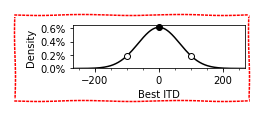

In [9]:
fig1, axs, axg = make_figure(1, 1, individual_width_inch=2.4, individual_height_inch=0.6,
                            left_inch=0.8, right_inch=0.05, top_inch=0.15, bottom_inch=0.45)

ax = axs[0,0]

x_plot = np.linspace(-270,270,201)

ax.plot(x_plot, pvdc.population_density_at(x_plot), '-k')
ax.plot(0, pvdc.population_density_at(0), 'ok', clip_on=None)
ax.plot(-100, pvdc.population_density_at(-100), 'ok', mfc='w')
ax.plot(+100, pvdc.population_density_at(+100), 'ok', mfc='w')
ax.set_xlabel("Best ITD")
ax.set_ylabel("Density")
ax.set_ylim(bottom=0)
ax.set_xlim(-270, 270)
ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(200))
ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(50))
ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(.002))
ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, pos: '{:.1%}'.format(x)))

fig1.savefig(f'{out_dir}/pv_figure_1C.svg', facecolor='none')
fig1.outline()
fig1.get_size_inches()


# Figure 2

Overview of recorded sub-populations

## Figure 2a

### Inset: ITD ranges

In [10]:
def figure_2a_inset_itd_ranges(ax = None, dc = None, decorate_inset = False):
    """"""
    if ax is None:
        ax = plt.gca()
    if dc is None:
        dc = pvdc

    spans = np.asarray([sd.best_itd_range for sd in dc.sites_overview_data])
    
    # HISTOGRAM
    ax.hist(spans, bins=np.arange(0,240,20), edgecolor='k', facecolor='.5')

    # DECORATION
    if decorate_inset:
        ax.set_title("ITD ranges [µs]", fontsize=10, pad=3)
        ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(100))
        ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(20))
        ax.text(.99, .98, "median\n{1:.1f}".format(np.mean(spans), np.median(spans)),
                 ha='right', va='top', color='k', fontsize=8, transform=ax.transAxes)
        ax.tick_params(labelsize=8)
    else:
        ax.set_title("ITD ranges [µs]")
        ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(100))
        ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(20))
        ax.text(.99, .98, "median\n{1:.1f}".format(np.mean(spans), np.median(spans)),
                 ha='right', va='top', color='k', transform=ax.transAxes)

### Inset: n units

In [11]:
def figure_2a_inset_n_units(ax = None, dc = None, decorate_inset = False):
    """"""
    if ax is None:
        ax = plt.gca()
    if dc is None:
        dc = pvdc

    n_units = np.asarray([sd.n_units for sd in dc.sites_overview_data])

    # HISTOGRAM
    ax.hist(n_units, bins=np.arange(2,15,1)+.5, edgecolor='k', facecolor='.5')

    # DECORATION
    if decorate_inset:
        ax.set_title("n parallel units", fontsize=10, pad=3)
        ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(6))
        ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(1))
        ax.text(.99, .98, "mean\n{0:.1f}".format(np.mean(n_units), np.median(n_units)),
                 ha='right', va='top', color='k', fontsize=8, transform=ax.transAxes)
        ax.tick_params(labelsize=8)
    else:
        ax.set_title("n parallel units")
        ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(6))
        ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(1))
        ax.text(.99, .98, "mean\n{0:.1f}".format(np.mean(n_units), np.median(n_units)),
                 ha='right', va='top', color='k', transform=ax.transAxes)

### Overview with/without insets

In [12]:
def figure_2a_population_overview(ax = None, dc = None, insets = True, colors=colors):
    """Population Overview
    """
    if ax is None:
        ax = plt.gca()
    if dc is None:
        dc = pvdc

    # For scatterplot colors:
    norm = mpl.colors.Normalize(vmin=1.,vmax=7.)
    cmap = mpl.cm.rainbow if colors else mpl.cm.gray_r
    # black/white variant:
    # cmap = mpl.cm.gray_r

    # Sort by mean best ITD:
    sites_overview_data_sort = sorted(
        dc.sites_overview_data, key=lambda sd: np.mean(sd.best_itds)
    )

    # SCATTER PLOT
    for ks, sd in enumerate(sites_overview_data_sort):
        ax.scatter(
            sd.best_itds, [ks] * len(sd.best_itds), s=6**2,
            c=sd.u_colors,
            norm=norm, cmap=cmap,
            marker = ('<' if sd.hemisphere_L else '>'),
            edgecolor = 'k', linewidth = .4,
            zorder=20
        )

    # LEGEND
    h_legendL = [
        ax.plot([cix * 1], [0], ls='None', ms=6,
            marker='<', mec='k', mew=.4,
            c=cmap(norm(cix)), label=f"{cix}"
        )
        for cix in range(1,8)
    ]
    h_legendR = [
        ax.plot([cix * 1], [0], ls='None', ms=6,
            marker='>', mec='k', mew=.4,
            c=cmap(norm(cix)), label=f"{cix}"
        )
        for cix in range(1,8)
    ]
    ax.legend(
        handles = [(hL[0], hR[0]) for hL, hR in zip(h_legendL, h_legendR)],
        labels = [hL[0].get_label() for hL, hR in zip(h_legendL, h_legendR)],
        handler_map = {tuple: mpl.legend_handler.HandlerTuple(ndivide=2)},
        loc = 'lower right', title = "Electrode",
        fancybox = False, framealpha = 1.0, edgecolor = 'k')
    ax.get_legend().get_frame().set_linewidth(.8)
    plt.setp((h_legendL, h_legendR), visible=False)

    # DECORATION
    ax.set_yticks([])
    ax.grid(True, axis='x', linestyle=':', zorder=-200)
    ax.axvline(0, color='k', lw=.8, zorder=-5)
    ax.set_ylabel("Sample-Populations")
    ax.set_xlabel("Units' best ITDs [µs]")

    ax.set_xlim(np.asarray([-1, 1]) * np.max(np.abs(ax.get_xlim())))

    # INSETS
    if not insets:
        return
    
    ax2 = ax.figure.add_axes([0, 0, 1, 1], label='inset a')
    ax2.set_zorder(200)
    ax2.set_axes_locator(InsetPosition(ax, [0.05, 0.78, 0.20, 0.15]))
    ax2.text(-.05, 1.01, "a", ha='right', va='bottom', color='k',
             fontsize=10, fontweight='bold', transform=ax2.transAxes)

    figure_2a_inset_itd_ranges(ax = ax2, dc = dc, decorate_inset = True)

    ax3 = ax.figure.add_axes([0, 0, 1, 1], label='inset b')
    ax3.set_zorder(200)
    # posx, posy, width, height - relative to ax, like with ax.transAxes:
    ax3.set_axes_locator(InsetPosition(ax, [0.05, 0.50, 0.20, 0.15]))
    ax3.text(-.05, 1.01, "b", ha='right', va='bottom', color='k',
             fontsize=10, fontweight='bold', transform=ax3.transAxes)

    figure_2a_inset_n_units(ax = ax3, dc = dc, decorate_inset = True)

    # A white rectangle behind the insets to cover the grid lines:
    rect = mpl.patches.Rectangle((0.00,0.44),0.258,0.51,
                                 linewidth=0,edgecolor='None',facecolor='w',
                                 transform=ax.transAxes, zorder=2)
    ax.add_patch(rect)

#### Usage

In [13]:
if do_usage:
    print("Population overview, with insets:")
    # fig, axs = plt.subplots(1,1,squeeze=False, figsize=(8,6))

    fig, axs, axg = make_figure(
        n_rows = 1, n_cols = 1,
        individual_width_inch=6, individual_height_inch=4.0,
        wspace_inch = 0.1, left_inch = 1.2, top_inch = 0.1,
        right_inch = 0.1, bottom_inch= .9,
        sharey = True,
    )

    figure_2a_population_overview(axs[0,0], insets=True, colors=True)
    plt.show(fig)

In [14]:
if do_usage:
    print("'Insets' alone:")
    fig, axs = plt.subplots(2,1,squeeze=False, sharey=True, figsize=(6,4), gridspec_kw=dict(hspace=.4))
    figure_2a_inset_itd_ranges(axs[0, 0])
    figure_2a_inset_n_units(axs[1, 0])
    plt.show(fig)

## Figure 2C Firing rate across the map

### Firing rate absolute ITD

In [15]:
def figure_2c_firing_rates_abs(ax = None, dc = None, show_fit = True, show_fit_results = False):
    """Population Firing Rates
    """
    if ax is None:
        ax = plt.gca()
    if dc is None:
        dc = pvdc

    best_itds = np.concatenate([sd.best_itds for sd in dc.sites_overview_data])
    abs_best_itds = np.abs(best_itds)
    
    max_resps = np.concatenate([sd.max_responses for sd in dc.sites_overview_data])
    
    if show_fit:
        plot_fun_x = np.asarray([abs_best_itds.min(), abs_best_itds.max()])
        reg_fun = lambda x, lrr: lrr.slope * np.asarray(x) + lrr.intercept
        LinRegResult = namedtuple('LinRegResult', "slope intercept r_value p_value std_err")
        reg_res = LinRegResult(*sp.stats.linregress(abs_best_itds, max_resps))

#     norm = mpl.colors.Normalize(vmin=1.,vmax=7.)
#     cmap = mpl.cm.rainbow

    # SCATTER PLOT
    ax.scatter(
        abs_best_itds, max_resps, s=4**2,
        c='k',
        marker = 'o',
        edgecolor = 'k', linewidth = .4,
        zorder=20
    )
    
    # LINEAR REGRESSION
    if show_fit:
        ax.plot(plot_fun_x, reg_fun(plot_fun_x, reg_res), c='.3', ls='-', lw=3, zorder=10)
        res_txt = (
            f"slope = {reg_res.slope:.1g}"
            f"\nintercept = {reg_res.intercept:.1f}"
            f"\n$r^2$ = {reg_res.r_value ** 2:.2f}"
            f"\n$p$ = {reg_res.p_value:.1g}"
        )
        print('Max Response:')
        print(res_txt)
        
        if show_fit_results:
            res_txt = (
                f"$r^2$ = {reg_res.r_value ** 2:.2f}"
                f"\n$p$ = {reg_res.p_value:.1g}"
            )
            h_all_txt = ax.text(.98, .98,
                    res_txt,
                    ha='right', va='top', transform=ax.transAxes, fontsize=12)

    # DECORATION
    ax.grid(True, axis='x', linestyle=':', zorder=-200)
    ax.set_ylabel("Max. response [spks/stim]")
    ax.set_xlabel("abs. Best ITDs [µs]")

    ax.set_ylim(bottom=0)

#### Usage

In [16]:
if do_usage:
    fig, axs, axg = make_figure(
        n_rows = 1, n_cols = 1,
        individual_width_inch=2.5, individual_height_inch=2.0,
        wspace_inch = 0.1, left_inch = 1.2, top_inch = 0.1,
        right_inch = 0.1, bottom_inch= .9,
        sharey = True,
    )
    figure_2c_firing_rates_abs(axs[0,0], show_fit=True, show_fit_results=True)
    # fig.savefig(os.path.expanduser('~/Desktop/PV-Fig1-Firing-Rates.png'), dpi=150)

## Figure 2B Frequency Tuning across the map

### Frequency Ranges absolute ITD

In [17]:
def figure_2b_frequency_ranges_abs(ax = None, dc = None, show_fit = True, show_fit_results = False):
    """Population Frequency Ranges
    """
    if ax is None:
        ax = plt.gca()
    if dc is None:
        dc = pvdc

    best_itds = np.concatenate([sd.best_itds for sd in dc.sites_overview_data])
    abs_best_itds = np.abs(best_itds)
    
    best_freqs = np.concatenate([sd.best_freqs if sd.best_freqs is not None else [np.nan] * sd.n_units for sd in dc.sites_overview_data])
    min_freqs = np.concatenate([sd.min_freqs if sd.min_freqs is not None else [np.nan] * sd.n_units for sd in dc.sites_overview_data])
    max_freqs = np.concatenate([sd.max_freqs if sd.max_freqs is not None else [np.nan] * sd.n_units for sd in dc.sites_overview_data])
    has_best_freq = np.isfinite(best_freqs)
    
    if show_fit:
        plot_fun_x = np.asarray([abs_best_itds.min(), abs_best_itds.max()])
        reg_fun = lambda x, lrr: lrr.slope * np.asarray(x) + lrr.intercept
        LinRegResult = namedtuple('LinRegResult', "slope intercept r_value p_value std_err")
        reg_res = LinRegResult(*sp.stats.linregress(abs_best_itds[has_best_freq], best_freqs[has_best_freq]))

#     norm = mpl.colors.Normalize(vmin=1.,vmax=7.)
#     cmap = mpl.cm.rainbow

    # CONNECTED SCATTER PLOT
    ax.plot(
        np.vstack([abs_best_itds, abs_best_itds]),
        np.vstack([min_freqs, max_freqs]),
        color = 'k',
        ls = '-', marker='None',
        lw=.4
    )
    ax.scatter(
        abs_best_itds, min_freqs, s=4**2,
        c='k',
        marker = 'o',
        edgecolor = 'k', linewidth = .4,
        zorder=20
    )
    ax.scatter(
        abs_best_itds, max_freqs, s=4**2,
        c='w',
        marker = 'o',
        edgecolor = 'k', linewidth = .4,
        zorder=20
    )
    
    # LINEAR REGRESSION
    if show_fit:
        ax.plot(plot_fun_x, reg_fun(plot_fun_x, reg_res), c='.3', ls='-', lw=3, zorder=10)
        res_txt = (
            f"slope {reg_res.slope:.1f}"
            f"\nintercept {reg_res.intercept:.1f}"
            f"\n$r^2$ = {reg_res.r_value ** 2:.2f}"
            f"\n$p$ = {reg_res.p_value:.1g}"
        )
        print('Best Frequencies:')
        print(res_txt)
        
        if show_fit_results:
            res_txt = (
                f"$r^2$ = {reg_res.r_value ** 2:.2f}"
                f"\n$p$ = {reg_res.p_value:.1g}"
            )
            h_all_txt = ax.text(.98, .98,
                    res_txt,
                    ha='right', va='top', transform=ax.transAxes, fontsize=12)

    # DECORATION
    ax.grid(True, axis='x', linestyle=':', zorder=-200)
    ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(1000))
    ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(500))
    ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, pos: f"{x/1000:.1f}"))
    ax.set_ylabel("Stim Frequency [kHz]")
    ax.set_xlabel("abs. Best ITDs [µs]")

#     ax.set_xlim(np.asarray([-1, 1]) * np.max(np.abs(ax.get_xlim())))
    ax.set_ylim(bottom=800, top=7400)

#### Usage

In [18]:
if do_usage:
    fig, axs, axg = make_figure(
        n_rows = 1, n_cols = 1,
        individual_width_inch=2.5, individual_height_inch=2.0,
        wspace_inch = 0.1, left_inch = 0.7, top_inch = 0.1,
        right_inch = 0.2, bottom_inch= .5,
        sharey = True,
    )
    figure_2b_frequency_ranges_abs(axs[0,0], show_fit = True, show_fit_results = True)
    fig.outline()

## Figure 2 - composed

Best Frequencies:
slope -11.9
intercept 5453.2
$r^2$ = 0.26
$p$ = 3e-14
Max Response:
slope = -0.02
intercept = 6.2
$r^2$ = 0.04
$p$ = 0.003


(array([6.8, 6.5]), array([17.272, 16.51 ]))

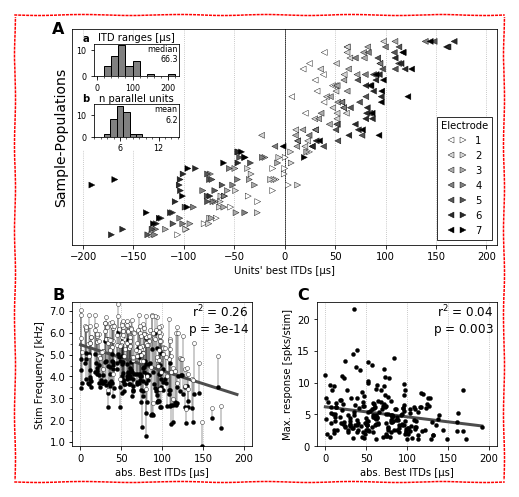

In [19]:
outer_right = 0.1
outer_left = 0.8
outer_top = 0.2
outer_bottom = 0.5
row1_height = 3.0
row2_height = 2.0
vert_space = 0.8


fig2 = plt.figure(figsize=(outer_left+2.5+0.9+2.5+outer_right, outer_top+row1_height+vert_space+row2_height+outer_bottom))

ax1 = fig2.add_axes_inch(top=outer_top, height=row1_height, left=outer_left, right=outer_right, label='A')
figure_2a_population_overview(ax = ax1, dc = pvdc)
ax1.subplot_indicator(va='center')
ax1.yaxis.label.set_fontsize(14)

ax2 = fig2.add_axes_inch(bottom=outer_bottom, height=row2_height, left=outer_left, width=2.5, label='B')
figure_2b_frequency_ranges_abs(ax = ax2, dc = pvdc, show_fit=True, show_fit_results=True)
ax2.subplot_indicator()
ax2.set_xlim(-10, 210)

ax3 = fig2.add_axes_inch(bottom=outer_bottom, height=row2_height, right=outer_right, width=2.5, label='C', sharex=ax2)
figure_2c_firing_rates_abs(ax = ax3, dc = pvdc, show_fit=True, show_fit_results=True)
ax3.subplot_indicator()
ax3.set_xlim(-10, 210)

fig2.savefig(f'{out_dir}/pv_figure_2.pdf')
fig2.savefig(f'{out_dir}/pv_figure_2.png')
fig2.savefig(f'{out_dir}/pv_figure_2.eps')

fig2.outline()
fig2.get_size_inches(), fig2.get_size_inches()*2.54

# Figure 3

Spread of responses (BC100)

## Figure 3A/5A/5B: Spread of responses

In [20]:
def figure_3a_spreading_responses(ax = None, dc = None, bc = 100,
                                  indicate_bc = False, indicate_stim = True,
                                  model_profile = True,
                                  report_rmse = 'print',
                                  show_optimized = False,
                                  colors = colors):
    if ax is None:
        ax = plt.gca()
    if dc is None:
        dc = pvdc
        
    # SCATTER PLOT
    ax.scatter(-dc.spreading_df['delta_itd_signed'],
               dc.spreading_df[f'mean_norm_resp_{bc}'],
               marker = '.', s = 3**2,
               color = bc_colors[bc] if colors else '.6')
    
    # DECORATION
    ax.set_xlim(left = -141, right = 141)
    ax.set_ylim(bottom=0)

    ax.set_xlabel("BestITD - StimITD")
    ax.set_ylabel("Norm. Response")
    ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(40))
    ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(20))

    ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(1))
    ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(.5))
    #ax.axhline(0, color='k', lw=.8)
    ax.axhline(1, color='k', lw=2, ls=':')

    # OPTIONAL INDICATORS
    if indicate_bc: # default: False
        trans = ax.transAxes + \
                mpl.transforms.ScaledTranslation(
                    +(bc_indicator_size)/4/72.,
                    -(bc_indicator_size)/4/72.,
                    ax.figure.dpi_scale_trans
                )
        ax.text(0.0, 1.0, f"BC = {bc}%", transform=trans,
                ha='left', va='top', fontsize=bc_indicator_size,
                color=bc_colors[bc] if colors else 'k',
                )
    if indicate_stim: # default: True
        trans = mpl.transforms.blended_transform_factory(ax.transData, ax.transAxes) + \
                mpl.transforms.ScaledTranslation(0, 5/72., ax.figure.dpi_scale_trans)
        ax.plot(0, 0, transform=trans, marker='v', mfc='w', mec='k',
                markersize=10, clip_on=False, zorder=100)
    if model_profile: # default: True
        spreading_fit_bc = dc.spreading_fit[bc]
        prof_x = make_cont_x(0, before=141, after=141, n=121)
        ax.plot(prof_x, spreading_fit_bc['model_profile'](prof_x),
                ls = '-',
                color = 'k' if colors else '.3',
                lw=2)
        if report_rmse:
            print('Model | BC = {bc:3} | amp = {amp:.2f} | sd = {sd:6.3f} | rmse = {rmse:.3f} | R$^2$ = {rsquare:4.3g}'.format(
                bc = bc,
                sd = spreading_fit_bc['model_profile'].w,
                rmse = spreading_fit_bc['model_rmse'],
                rsquare = spreading_fit_bc['model_rsquare'],
                amp = spreading_fit_bc['model_scale'],
            ))
            if report_rmse is True:
                trans = ax.transAxes + \
                        mpl.transforms.ScaledTranslation(
                            -(bc_indicator_size)*0.25/72.,
                            -(bc_indicator_size)*0.25/72.,
                            ax.figure.dpi_scale_trans
                        )
                ax.text(1.0, 1.0, "RMSE={rmse:.2f} amp={amp:.2f} sd={sd:.2f} R$^2$={rsquare:.3f}".format(
                            rmse = spreading_fit_bc['model_rmse'],
                            sd = spreading_fit_bc['model_profile'].w,
                            rsquare = spreading_fit_bc['model_rsquare'],
                            amp = spreading_fit_bc['model_scale'],
                        ),
                        transform=trans,
                        ha='right', va='top', fontsize=bc_indicator_size,
                        color='k',
                        )
        if show_optimized:
            ax.plot(prof_x, spreading_fit_bc['scale'] * spreading_fit_bc['optimal_profile'](prof_x),
                    ls = (0, (2,1)),
                    color = 'r' if colors else 'k',
                    lw=3)
            if report_rmse:
                rmse = spreading_fit_bc['optimal_rmse']
                print('Fit   | BC = {bc:3} | amp = {amp:.2f} | sd = {sd:6.3f} | rmse = {rmse:.3f} | R$^2$ = {rsquare:4.3g}'.format(
                    bc = bc,
                    sd = spreading_fit_bc['optimal_profile'].w,
                    rmse = spreading_fit_bc['optimal_rmse'],
                    rsquare = spreading_fit_bc['optimal_rsquare'],
                    amp = spreading_fit_bc['scale'],
                ))
                if report_rmse is True:
                    trans = ax.transAxes + \
                            mpl.transforms.ScaledTranslation(
                                -(bc_indicator_size)*0.25/72.,
                                -(bc_indicator_size)*1.40/72.,
                                ax.figure.dpi_scale_trans
                            )
                    ax.text(1.0, 1.0, "RMSE={rmse:.2f} amp={amp:.2f} sd={sd:.2f} R$^2$={rsquare:.3f}".format(
                                rmse = spreading_fit_bc['optimal_rmse'],
                                sd = spreading_fit_bc['sd'],
                                rsquare = spreading_fit_bc['optimal_rsquare'],
                                amp = spreading_fit_bc['scale'],
                            ), transform=trans,
                            ha='right', va='top', fontsize=bc_indicator_size,
                            color='r' if colors else 'k',
                            )


#### Usage

In [21]:
if do_usage:
    print('All three BC-Levels:')
    fig, axs, axg = make_figure(
        n_rows = 3, n_cols = 1,
        individual_width_inch=4, individual_height_inch=2,
        hspace_inch = 0.3, wspace_inch = 0.1,
        left_inch = 0.7, top_inch = 0.3,
        right_inch = 0.1, bottom_inch= .5,
#         sharey = True,
    )

    kwargs = dict(
        indicate_bc=True,
        indicate_stim=True,
        model_profile=True,
        show_optimized=True,
        report_rmse=True,
    )
    figure_3a_spreading_responses(axs[0,0], pvdc, bc=100, **kwargs)
    axs[0,0].subplot_indicator('3A')
    figure_3a_spreading_responses(axs[1,0], pvdc, bc=40, **kwargs)
    axs[1,0].subplot_indicator('5A')
    figure_3a_spreading_responses(axs[2,0], pvdc, bc=20, **kwargs)
    axs[2,0].subplot_indicator('5B')
    
    for ax in axs[:,0]:
        ax.set_ylim(top = 2.5)

    plt.setp(axs[:-1,:], xlabel='')
    
    fig.savefig('C:/Users/roland/Desktop/spreading_scaledNormalization_fitted.pdf')
    fig.savefig('C:/Users/roland/Desktop/spreading_scaledNormalization_fitted.png')
    
    fig.outline()
    plt.show(fig)


In [22]:
if do_usage:
#     raise RuntimeWarning('This cell might change your data in unexpected ways')
    print('All three BC-Levels:')
    fig, axs, axg = make_figure(
        n_rows = 3, n_cols = 2,
        individual_width_inch=4, individual_height_inch=2,
        hspace_inch = 0.3, wspace_inch = 0.1,
        left_inch = 0.8, top_inch = 0.3,
        right_inch = 0.1, bottom_inch= .5,
#         sharey = True,
    )
    backup_options = pvdc.options
    pvdc.options = pvdc.options.copy()
    try:
        del pvdc.spreading_fit
    except:
        pass
    pvdc.options['spread_fit_params'] = 'sd'

    kwargs = dict(
        indicate_bc=False,
        indicate_stim=True,
        model_profile=True,
        show_optimized=True,
        report_rmse=True,
    )
    figure_3a_spreading_responses(axs[0,0], pvdc, bc=100, **kwargs)
    axs[0,0].subplot_indicator('3A\n100%', va='center')
    figure_3a_spreading_responses(axs[1,0], pvdc, bc=40, **kwargs)
    axs[1,0].subplot_indicator('5A\n40%', va='center')
    figure_3a_spreading_responses(axs[2,0], pvdc, bc=20, **kwargs)
    axs[2,0].subplot_indicator('5B\n20%', va='center')
    
    for ax in axs.flatten():
        ax.set_ylim(top = 2.5)

    del pvdc.spreading_fit
    pvdc.options['spread_fit_params'] = 'sd_scale'

    figure_3a_spreading_responses(axs[0,1], pvdc, bc=100, **kwargs)
    figure_3a_spreading_responses(axs[1,1], pvdc, bc=40, **kwargs)
    figure_3a_spreading_responses(axs[2,1], pvdc, bc=20, **kwargs)

    del pvdc.spreading_fit
    pvdc.options = backup_options

        
    plt.setp(axs[:-1,:], xlabel='')
    plt.setp(axs[:,1:], yticklabels=[])
    plt.setp(axs[:,1:], ylabel="")
    
    fig.savefig('C:/Users/roland/Desktop/spreading_scaledNormalization_fitted.pdf')
    fig.savefig('C:/Users/roland/Desktop/spreading_scaledNormalization_fitted.png')
    
    fig.outline()
    plt.show(fig)


In [23]:
if do_usage:
    for bc in [100, 40, 20]:
        print("BC =", bc)
        print(f"Model   SD = {pvdc.spreading_fit[bc]['model_profile'].w:.3f}")
        print(f"Optimal SD = {pvdc.spreading_fit[bc]['optimal_profile'].w:.3f}")


## Figure 3B Response distribution (heatmap)

In [24]:
def figure_3b_response_distribution(ax = None, dc = None, cax = None,
                                    colors = colors, colorbar_kwargs = {}):
    """Response distribution heatmap"""
    if ax is None:
        ax = plt.gca()
    else:
        plt.sca(ax)
    if dc is None:
        dc = pvdc

    # meshgrid for plotting:
    X, Y = np.meshgrid(
        np.array(dc.default_itds + [260]) - 10, # stimulus ITDs
        dc.spreading2_bins                      # units' best ITDs
    )

    # HEAT MAP
    h = ax.pcolormesh(X, Y, dc.spreading2_out_vals,
                      cmap = 'brg' if colors else 'gray_r',
                      vmin=0, vmax=1)

    # COLORBAR
    if not 'label' in colorbar_kwargs:
        colorbar_kwargs['label'] = "Normalized Response"
    if not 'ticks' in colorbar_kwargs:
        colorbar_kwargs['ticks'] = [0, 1]
    cb = plt.colorbar(h, cax = cax, **colorbar_kwargs)
    
    # DECORATION
    ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(80))
    ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(40))

    if colorbar_kwargs.get('orientation', 'vertical') == 'vertical':
#         cax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(1.0))
#         cax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.2))
        cax.yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%.0f'))
    else:
        cax.xaxis.set_ticks_position('top')
#         cax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(1.0))
#         cax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.2))
#         cax.xaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%.0f'))
        
    
    ax.set_xlabel("Stimulus ITD")
    ax.set_ylabel("Unit's best ITD")


#### Usage

In [25]:
if do_usage:
    print('Response distribution heatmap:')
    fig, axs, axg = make_figure(
        n_rows = 1, n_cols = 1,
        individual_width_inch=5.0, individual_height_inch=2.8,
        hspace_inch = 0.3, wspace_inch = 0.1,
        left_inch = 1.0, top_inch = 0.1,
        right_inch = 1.1, bottom_inch= .7,
    )
    fig_dd = fig.dimensions_dict
    cax_shrink = 0.94
    cax = fig.add_axes(
        (
            1 - (fig_dd['right_inch'] - .2) / fig_dd['w'], # left
            fig_dd['bottom_inch'] / fig_dd['h'] + (1-cax_shrink)/2* fig_dd['individual_height_inch'] / fig_dd['h'], # bottom
            .2 / fig_dd['w'], # width
            cax_shrink * fig_dd['individual_height_inch'] / fig_dd['h'], # height
        ),
        label="colorbar",
    )

    figure_3b_response_distribution(axs[0,0], cax=cax)
    fig.outline()

## Figure 5C PV Model Results

In [26]:
def figure_5c_model_results(ax = None, dc = None, cax = None,
                                    colors = colors):
    """PV Model Results"""
    if ax is None:
        ax = plt.gca()
    else:
        plt.sca(ax)
    if dc is None:
        dc = pvdc

    # ERRORBARS
    azimuth_markers = {-75: 'v', -55: '^', 55: 's', 75: 'o'}
    for kaz, azimuth in enumerate(dc.pv_fit2021.azimuths):
        ax.errorbar(dc.pv_mod2011.bcs, dc.pv_mod2011.m[kaz], yerr=dc.pv_mod2011.s[kaz],
                     label='2011 PV model' if kaz == 0 else None,
                     color = '.5', lw=2, ls='-',
                     marker=azimuth_markers[azimuth], mfc='w',
                     capsize=False, capthick=2,
                     )
        ax.errorbar(dc.pv_fit2021.bcs, dc.pv_fit2021.m[kaz], yerr=dc.pv_fit2021.s[kaz],
                     label='Fitted SDs' if kaz == 0 else None,
                     color = 'k', lw=2, ls='-', zorder = 10,
                     marker=azimuth_markers[azimuth], mfc='w', capsize=3, elinewidth=2, capthick=2,
                     )

    # DECORATION
    ax.set_xlabel('Binaural Correlation')
    ax.set_ylabel('Estimated Direction [deg]')
    ax.set_xlim(5, 105)
    ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(20))
    ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(10))
    ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(20))

In [27]:
if do_usage:
    print('PV Model Results:')
    fig, axs, axg = make_figure(
        n_rows = 1, n_cols = 1,
        individual_width_inch=2.0, individual_height_inch=1.8,
        hspace_inch = 0.3, wspace_inch = 0.1,
        left_inch = 1.0, top_inch = 0.1,
        right_inch = 1.1, bottom_inch= .7,
    )
    figure_5c_model_results(ax = axs[0,0], dc = pvdc)

In [28]:
def model_output_text(model_runner):
    backup_float_format = pd.options.display.float_format
    pd.options.display.float_format = "{:,.2f}".format
    idx = pd.Index(model_runner.bcs, name='BC')
    cols = pd.MultiIndex.from_tuples([(az, col) for az in model_runner.azimuths for col in ['mean', 'std', 'err']], names=['azi', 'property'])
    df = pd.DataFrame([], index=idx, columns=cols)
    for kaz, azimuth in enumerate(model_runner.azimuths):
        df[(azimuth, 'mean')] = model_runner.m[kaz]
        df[(azimuth, 'std')] = model_runner.s[kaz]
        df[(azimuth, 'err')] = azimuth - model_runner.m[kaz]
    df[('mean(±75)', 'mean')] = (df[(-75, 'mean')].abs() + df[(+75, 'mean')].abs()) / 2
    df[('mean(±75)', 'std')]  = (df[(-75, 'std')].abs()  + df[(+75, 'std')].abs()) / 2
    df[('mean(±75)', 'err')]  = (df[(-75, 'err')].abs()  + df[(+75, 'err')].abs()) / 2
    df[('mean(±55)', 'mean')] = (df[(-55, 'mean')].abs() + df[(+55, 'mean')].abs()) / 2
    df[('mean(±55)', 'std')]  = (df[(-55, 'std')].abs()  + df[(+55, 'std')].abs()) / 2
    df[('mean(±55)', 'err')]  = (df[(-55, 'err')].abs()  + df[(+55, 'err')].abs()) / 2
    
    high = lambda s: 'background: lightpink;'
    def highlight(df):
        s = df.copy()
        s.loc[:,:] = ''
        s.loc[:, (slice(None), 'mean')] += 'background-color: #fdd; border-left: 1px solid black;'
        s.loc[:, (slice(None), 'err')] += 'background-color: #ffc;'
        #s.loc[[20,40,100], :] += 'font-weight: bold; border-top:2px solid gray; border-bottom:2px solid gray;'
        s.loc[~s.index.get_level_values('BC').isin([20,40,100]), :] += 'color: #555;'
        return s
        
    
    display(df[['mean(±75)', 'mean(±55)'] + list(model_runner.azimuths)].style.apply(highlight, axis=None).format("{:.1f}".format))


    pd.options.display.float_format = None

print("With 2011 values")
print("================")
model_output_text(pvdc.pv_mod2011)

print("With 2021 values")
print("================")
model_output_text(pvdc.pv_fit2021)

With 2011 values


With 2021 values


## Figure 5D Spreading Fits

In [29]:
def figure_5c_spreading_fits(ax = None, dc = None, cax = None,
                                    colors = colors):
    """PV Model Results"""
    if ax is None:
        ax = plt.gca()
    else:
        plt.sca(ax)
    if dc is None:
        dc = pvdc

        
    bc_style = {
        100: dict(ls = '-'),
        40: dict(ls = (0, (2,1))),
        20: dict(ls = (0, (1, 1))),
    }
    # ERRORBARS
    for bc in [20, 40, 100]:
        spreading_fit_bc = dc.spreading_fit[bc]
        prof_x = make_cont_x(0, before=141, after=141, n=121)
        ax.plot(prof_x, spreading_fit_bc['scale'] * spreading_fit_bc['optimal_profile'](prof_x),
                **bc_style[bc],
                color = 'k',
                lw=2)

    # DECORATION
    ax.set_xlim(left = -141, right = 141)
    ax.set_ylim(bottom=0, top=1.2)
#     ax.axhline(1, color='k', lw=2, ls=':')

    ax.set_xlabel("BestITD - StimITD")
    ax.set_ylabel("Norm. Response")
    ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(120))
    ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(20))

    ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(1))
    ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(.5))


In [30]:
if do_usage:
    print('All spreading sd fits together:')
    fig, axs, axg = make_figure(
        n_rows = 1, n_cols = 1,
        individual_width_inch=1.0, individual_height_inch=0.8,
        hspace_inch = 0.3, wspace_inch = 0.1,
        left_inch = .7, top_inch = 0.1,
        right_inch = 0.1, bottom_inch= .5,
    )
    figure_5c_spreading_fits(ax = axs[0,0], dc = pvdc)
    fig.savefig(f'{out_dir}/../pv_figure_spreading_combined.pdf')


## Figure 3C - Side Peak Responses

In [31]:
def figure_3c_sidepeak_responses(ax = None, dc = None, colors = colors):
    """PV Model Results"""
    if ax is None:
        ax = plt.gca()
    else:
        plt.sca(ax)
    if dc is None:
        dc = pvdc

    sps_indexes = dc.sps_indexes
    #fig, ax = plt.subplots(1,1, figsize=(4.5,3), gridspec_kw=dict(left=0.12, right=0.85, top=0.95, bottom=0.15))
    sp_counts, sp_bins = np.histogram(sps_indexes, bins=np.linspace(0,1,41))
    sp_counts_rel = sp_counts / np.sum(sp_counts)
    ax.bar(sp_bins[:-1], sp_counts_rel * 100, width=np.diff(sp_bins[:2]), align='edge', color='.7', edgecolor='.5')


    # ax.axvline(np.percentile(sps_indexes, 75), label=f"75th-percentile ({np.percentile(sps_indexes, 75):.3f})", ls='-', color='k')
    # ax.axvline(np.percentile(sps_indexes, 50), label=f"50th-percentile ({np.percentile(sps_indexes, 50):.3f})", ls='--', color='k')
    # ax.axvline(np.percentile(sps_indexes, 25), label=f"25th-percentile ({np.percentile(sps_indexes, 25):.3f})", ls=':', color='k')

    ax.set_xlim(0, 1)
    ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(0.5))
    ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.1))

    ax2 = ax.twinx()
    ax2.set_zorder(100)
    ax2.set_ylim(0, 100)

    val_025 = np.searchsorted(np.sort(sps_indexes), 0.25) / sps_indexes.size
    style_025 = dict(ls='--', color='k', lw=1)
    ax2.axvline(0.25, ymax = val_025, label=f"{val_025:.1%} $\leq$ 0.25", **style_025, zorder=100)
    ax2.axhline(val_025 * 100, xmin = 0.25, xmax=1.00, **style_025)
#     ax2.text(0.95, val_025 * 100 + 2, f"{val_025:.0%} $\leq$ 0.25", color=style_025.get('color','k'), ha='right', va='bottom')
#     ax2.text(0.32, val_025 * 100 - 2, f"{val_025:.0%}", color=style_025.get('color','k'), ha='left', va='center', fontsize=10)

    val_010 = np.searchsorted(np.sort(sps_indexes), 0.10) / sps_indexes.size
    style_010 = dict(ls='-.', color='k', lw=1)
    ax2.axvline(0.10, ymax = val_010, label=f"{val_010:.1%} $\leq$ 0.10", **style_010, zorder=100)
    ax2.axhline(val_010 * 100, xmin = 0.10, xmax=1.00, **style_010)
#     ax2.text(0.95, val_010 * 100 - 2, f"{val_010:.0%} $\leq$ 0.10", color=style_010.get('color','k'), ha='right', va='top')
#     ax2.text(0.32, val_010 * 100 - 2, f"{val_010:.0%}", color=style_010.get('color','k'), ha='left', va='center', fontsize=10)

    ax2.plot(np.sort(sps_indexes), np.arange(sps_indexes.size) / sps_indexes.size * 100, color='k', lw=2)

    ax.set_xlabel("Relative Side Peak Response")
    ax.set_ylabel("Percentage of neurons")
    ax2.set_ylabel("Cum. Percentage")
    #ax2.legend(loc='center right', frameon=False)

    # ITD-tuning curve of exemplary unit 3a:
    d = dc.exemplary_itd_resp.loc[100, '3a'].reset_index()
    x = np.linspace(0,1,d.shape[0])
    y = (d['mean'] - d['mean'].min()).values
    y /= y.max()

    spr = side_peak_relation(x,y)
    print(spr)
    
    ax2.add_patch(mpl.patches.Rectangle(
        (0.45, 0.32), 0.47, 0.45,
        facecolor = 'white', fill=True, edgecolor='k', lw=.8, zorder=100, transform=ax.transAxes,
        )
    )

    ax3 = ax.figure.add_axes([0, 0, 1, 1], label='inset b')
    ax3.set_axes_locator(InsetPosition(ax, [0.65, 0.40, 0.25, 0.30]))
    ax3.set_zorder(200)
    ax3.set_xlim(0,1)
    ax3.set_ylim(0,1)
    ax3.set_xticks([])
    ax3.set_yticks([0,spr['side_Y'],1])
    ax3.yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%.2f'))
    ax3.spines['top'].set_visible(False)
    ax3.spines['right'].set_visible(False)
    ax3.spines['bottom'].set_visible(False)

    ax3.tick_params(labelsize=8)
#     ax3.xaxis.label.set_fontsize(8)
    ax3.plot(x,y, c='.5', clip_on=False)
    #ax3.plot([0, spr['side_X']], [spr['side_Y'],spr['side_Y']], c='r')
    ax3.plot([spr['side_X']], [spr['side_Y']], '.k')


In [32]:
if do_usage:
    print('Side Peak Responses:')
    fig, axs, axg = make_figure(
        n_rows = 1, n_cols = 1,
        individual_width_inch=2.5-.5, individual_height_inch=1.5,
        hspace_inch = 0.3, wspace_inch = 0.1,
        left_inch = 0.7, top_inch = 0.2,
        right_inch = 0.1+.5, bottom_inch= .5,
    )
    figure_3c_sidepeak_responses(axs[0,0])
    fig.outline()

## Figure 3 - composed

1.3
Model | BC = 100 | amp = 1.00 | sd = 41.203 | rmse = 0.193 | R$^2$ = 0.605
Fit   | BC = 100 | amp = 1.00 | sd = 34.005 | rmse = 0.176 | R$^2$ = 0.671
{'max_X': 0.6666666666666666, 'max_Y': 1.0, 'min_X': 0.41666666666666663, 'min_Y': 0.0, 'side_X': 0.25, 'side_Y': 0.25252525252525254, 'diff_Y': 1.0, 'rel_Y': 0.25252525252525254}


(array([3.3, 6. ]), array([ 8.382, 15.24 ]))

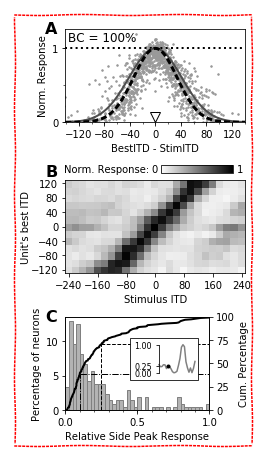

In [33]:
outer_right = 0.1
outer_left = 0.7
outer_top = 0.2
outer_bottom = 0.5
row2_width = 2.5
row1_height = row2_width/25*13
row2_height = row2_width/25*13
print(row2_height)
vert_space = 0.8
vert_space2 = 0.6

fig3 = plt.figure(figsize=(outer_left+row2_width+outer_right, outer_top+row1_height+vert_space+row2_height+vert_space2+row1_height+outer_bottom))

ax1 = fig3.add_axes_inch(top=outer_top, height=row1_height, left=outer_left, right=outer_right, label='A')
figure_3a_spreading_responses(ax1, pvdc, bc=100, indicate_bc=True, show_optimized=True)
ax1.subplot_indicator(va='center')
# ax1.yaxis.label.set_fontsize(14)

ax2 = fig3.add_axes_inch(top=outer_top+row1_height+vert_space, height=row2_height, left=outer_left, width=row2_width, label='B')
# ax2_cax = fig3.add_axes_inch(bottom=outer_bottom, height=row2_height, left=outer_left+row2_width+0.1, width=0.1, label='B-colorbar')
ax2_cax = fig3.add_axes_inch(top=outer_top+row1_height+vert_space-.2, height=.1, right=outer_right+12/72, width=1, label='B-colorbar')
figure_3b_response_distribution(ax2, pvdc, cax=ax2_cax,
                                colorbar_kwargs={'orientation': 'horizontal', 'ticks': [], 'label': ''})

trans_left = ax2_cax.transAxes + mpl.transforms.ScaledTranslation(-4/72., 0, ax2_cax.figure.dpi_scale_trans)
ax2_cax.text(0, .5, '0', ha='right', va='center', transform=trans_left)
trans_right = ax2_cax.transAxes + mpl.transforms.ScaledTranslation(+4/72., 0, ax2_cax.figure.dpi_scale_trans)
ax2_cax.text(1, .5, '1', ha='left', va='center', transform=trans_right)
trans_label = ax2_cax.transAxes + mpl.transforms.ScaledTranslation(-12/72., 0, ax2_cax.figure.dpi_scale_trans)
ax2_cax.text(0, .5, 'Norm. Response:', ha='right', va='center', transform=trans_label)
ax2.subplot_indicator(va='bottom')
ax2.set_ylabel(ax2.get_ylabel(), labelpad=0)
# ax2_cax.set_ylabel('Norm. Response', labelpad=-6)

ax3 = fig3.add_axes_inch(top=outer_top+row1_height+vert_space+row2_height+vert_space2, height=row1_height, left=outer_left, right=outer_right+.5, label='C')
figure_3c_sidepeak_responses(ax3, pvdc)
ax3.subplot_indicator(va='center')
# ax1.yaxis.label.set_fontsize(14)


fig3.savefig(f'{out_dir}/pv_figure_3.pdf')
fig3.savefig(f'{out_dir}/pv_figure_3.png')
fig3.savefig(f'{out_dir}/pv_figure_3.eps')

fig3.outline()
fig3.get_size_inches(), fig3.get_size_inches() * 2.54


# Figure 4

## Figure 4A ITD tuning plots

In [34]:
def figure_4a_itd_tuning_plots(ax = None, dc = None, axs = None, axg = None,
        normalize = False, sharey = True, colors = colors,
        show_unitname = True, show_bestitd_txt = True, show_bestitd_line = True,
        show_spont = False,
    ):
    if ax is None:
        pass
        #ax = plt.gca()
    else:
        raise ValueError('Cannot currently work with one given ax. Use axs and axg instead.')
        plt.sca(ax)
    if dc is None:
        dc = pvdc

    axl = axs.flatten()
        
    s = dc.exemplary_site
    resp = dc.exemplary_itd_resp
    u_spont = dc.exemplary_itd_spont
    units = dc.exemplary_itd_units
    
    u_color = unit_colors(s)
    
    h_best_itd_line = []
    h_best_itd_text = []

    for ku, (unitname, u) in enumerate(units.items()):
        ax = axl[ku]
        # Tuning curves at BC = 100:
        d = resp.loc[100, unitname].reset_index()
        
        # Normalization factor:
        u_max_norm = resp.loc[100, (unitname, 'mean')].max() if normalize else 1.0
        # Best ITD:
        best_itd = u.get_best_itd()
        
        # TUNING CURVE WITH ERRORBARS
        ax.errorbar(d['itd'], d['mean'] / u_max_norm, yerr=d['sem'] / u_max_norm,
                    label=f"{unitname}",
                    color=u_color[unitname] if colors else 'k',
                    lw = 2 if colors else 1,
                    marker = 'None',
        )
        
        # DECORATION per Unit
        trans_txt_ur = ax.transAxes + \
                mpl.transforms.ScaledTranslation(
                    -0.2*10./72.,
                    -0.2*10./72.,
                    ax.figure.dpi_scale_trans
                )
        trans_txt_ul = ax.transAxes + \
                mpl.transforms.ScaledTranslation(
                    +0.2*10./72.,
                    -0.2*10./72.,
                    ax.figure.dpi_scale_trans
                )
        if show_unitname:
            # Bold unit name:
            ax.text(1.0, 1.0, f"U{u.channel()}" if show_unitname == 'c' else f"U{unitname[:1]}", va="top", ha="right",
                    transform=trans_txt_ur,
                    fontsize=10, fontweight="bold")
        if show_bestitd_txt:
            h_best_itd_text.append(
                ax.text(0, 1, f"{best_itd:.1f} µs", va="top", ha="left",
                        transform = trans_txt_ul,
                        fontsize=10, fontweight="normal", color="k",
                        bbox=dict(boxstyle='square,pad=0.1', fc='w', ec='none'),
                )
            )
        if show_spont:
            # Spontaneous rate axhline
            ax.axhline(u_spont[unitname] / u_max_norm, color = 'k', zorder = -2, lw=.8)
        if show_bestitd_line:
            h_best_itd_line.append(
                ax.axvline(best_itd, color='k', linestyle=':')
            )
        
    # DECORATION
    axg.set_xlabel("Stimulus ITD [µs]", labelpad=20)
    if normalize:
        axg.set_ylabel("Norm.\nResponse", labelpad=30)
    else:
        axg.set_ylabel("Response\n[spks/stim]", labelpad=30)

    plt.setp([ax.xaxis for ax in axl],
             major_locator = mpl.ticker.MultipleLocator(120),
             minor_locator = mpl.ticker.MultipleLocator(40),
    )
    if normalize:
        plt.setp([ax.yaxis for ax in axl],
                 major_locator = mpl.ticker.MultipleLocator(0.5),
                 minor_locator = mpl.ticker.MultipleLocator(0.1),
                 major_formatter = mpl.ticker.FormatStrFormatter("%.1f"),
        )
    else:
        plt.setp([ax.yaxis for ax in axl],
                 major_locator = mpl.ticker.MultipleLocator(2),
                 major_formatter = mpl.ticker.FormatStrFormatter("%.0f"),
        )
    for ax in axl:
        ax.set_ylim(bottom = 0)
    if sharey:
        if normalize:
            ylim_top = 1.35
        else:
            ylim_top = max([ax.get_ylim()[1] for ax in axl])
        for ax in axl:
            ax.set_ylim(top = ylim_top)


#### Usage

In [35]:
if do_usage:
    fig, axs, axg = make_figure(
        1, len(pvdc.exemplary_itd_units),
        individual_height_inch=0.8, individual_width_inch=1.2,
        wspace_inch=.1,
        left_inch=0.8, right_inch=0.1,
        bottom_inch=0.5, top_inch=0.2,
    )

    figure_4a_itd_tuning_plots(dc=pvdc, axs=axs, axg=axg, normalize=False)
    plt.setp(axs, xlim=(-200, 200))
    plt.setp(axs[:,1:], yticklabels=[])
    axg.subplot_indicator('A', va='center')

    fig.outline()
    print(fig.get_size_inches())


## Figure 4B/6A Population response profiles

In [36]:
def figure_4b_population_response_profile(ax = None, dc = None, axs = None, axg = None,
        bc = 100, indicate_bc = False, report_rmse = False,
        colors = colors,
    ):
    if ax is None:
        pass
        #ax = plt.gca()
    else:
        raise ValueError('Cannot currently work with one given ax. Use axs and axg instead.')
        plt.sca(ax)
    if dc is None:
        dc = pvdc

    axl = axs.flatten()

    s = dc.exemplary_site
    u_color = unit_colors(s)
    units = s.units
    r = s.recs['itd_pairs_bc', 0]
    best_itds = pd.Series((u.get_best_itd() for u in s.units.values()), index=s.units.keys())
    max_responses = pd.Series((u.get_max_response(bc=bc) for u in s.units.values()), index=s.units.keys())
    resp = r.responses().xs(bc, level='bc').divide(max_responses).groupby('itd').agg(['mean', 'sem', 'std'])
    if not hasattr(s, 'showcase_stim_itds'):
        dc._exemplary_showcase_stim_itds()
    stim_itds = sorted(s.showcase_stim_itds)

    estimators = sorted(
        dc.get_exemplary_site_estimator(bc=bc, stim_itd = stim_itds),
        key=lambda se: se['stim_itd']
    )
    
    itd_plot = make_cont_x(stim_itds, best_itds)
    
    for ke, e in enumerate(estimators):
        estimator = e['estimator']
        stim_itd = e['stim_itd']
        ax = axl[ke]

        ax.set_title("{} µs".format(stim_itd))
        # Model prediction:
        ax.plot(itd_plot, estimator.f_mod(itd_plot), ls='-', c='k' if colors else '.5', lw=2)
        # Responses (colored scatter + errorbars)
        for ku in units.keys():
            ax.errorbar(
                x = best_itds[ku],
                y = resp.loc[stim_itd, (ku, 'mean')],
                yerr = resp.loc[stim_itd, (ku, 'sem')],
                color = u_color[ku] if colors else 'k',
                marker='o', mfc = u_color[ku] if colors else 'w',
                mec = 'None' if colors else 'k',
            )
        # Stimulus indicator:
        ax.vmarker(stim_itd)
        # Highlight estimated ITD
        trans_txt = ax.transAxes + \
                mpl.transforms.ScaledTranslation(
                    +0.0*10./72.,
                    -0.2*10./72.,
                    ax.figure.dpi_scale_trans
                )
        ax.text(.5, 1, f"estimate = {estimator.itd:.1f} µs", transform=trans_txt,
                ha='center', va='top', fontsize=10, color=bc_colors[bc] if colors else 'k')
        ax.vmarker(estimator.itd, markersize=6,
                   mfc=bc_colors[bc] if colors else 'k',
                   mec=bc_colors[bc] if colors else 'k',
                   zorder=101)
        # Plot fitted function:
        ax.plot(itd_plot, estimator.f_opt(itd_plot), ls=':', c=bc_colors[bc] if colors else 'k', lw=3)
        
        if report_rmse:
            x = np.array([best_itds[ku] for ku in sorted(units.keys())])
            y = np.array([resp.loc[stim_itd, (ku, 'mean')] for ku in sorted(units.keys())])
            rmse = np.sqrt(np.mean((estimator.f_opt(x) - y) ** 2))
            trans_txt = ax.transAxes + \
                    mpl.transforms.ScaledTranslation(
                        +0.0*10./72.,
                        -1.4*10./72.,
                        ax.figure.dpi_scale_trans
                    )
            ax.text(.5, 1, f"rmse = {rmse:.3f}", transform=trans_txt,
                    ha='center', va='top', fontsize=10, color='k')
            # Unfitted:
            rmse_mod = np.sqrt(np.mean((estimator.f_mod(x) - y) ** 2))
            trans_txt = ax.transAxes + \
                    mpl.transforms.ScaledTranslation(
                        +0.0*10./72.,
                        -2.6*10./72.,
                        ax.figure.dpi_scale_trans
                    )
            ax.text(.5, 1, f"rmse_mod = {rmse_mod:.3f}", transform=trans_txt,
                    ha='center', va='top', fontsize=10, color='.5')

    # DECORATION
    for ax in axl:
        ax.set_ylim(0, 2.1)
        ax.set_xlim(itd_plot[0]-5, itd_plot[-1]+5)
        ax.yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%.1f'))
        ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(1.0))
        ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.5))
        ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(100))
        ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(20))


    if indicate_bc:
        trans = axl[0].transAxes + \
                mpl.transforms.ScaledTranslation(
                    0,
                    -(10)*1.4/72.,
                    axl[0].figure.dpi_scale_trans
                )
        axl[0].text(0.5, 1.0, f"BC = {bc}%", transform=trans,
                ha='center', va='top', fontsize=10,
                color=bc_colors[bc] if colors else 'k',
                )
    axg.set_xlabel("ITD [µs]",labelpad=20)
    axg.set_ylabel("Norm. Response",labelpad=28)
    axg.set_title("Stimulus ITD", pad=20, fontweight='bold')

#### Usage

In [37]:
if do_usage:
    fig, axs, axg = make_figure(
        1, len(pvdc.get_exemplary_site_estimator(bc=100)),
        individual_height_inch=1.2, individual_width_inch=1.525,
        wspace_inch=.1, hspace_inch=0.7,
        left_inch=0.8, right_inch=0.1,
        bottom_inch=0.5, top_inch=0.5,
    )
    print(fig.get_size_inches())

    figure_4b_population_response_profile(axs=axs, axg = axg)
    plt.setp(axs[:,1:], yticklabels=[])
    axg.subplot_indicator('A')

    fig.outline()

    bc = 20

    fig, axs, axg = make_figure(
        1, len(pvdc.get_exemplary_site_estimator(bc=bc)),
        individual_height_inch=1.2, individual_width_inch=1.525,
        wspace_inch=.1, hspace_inch=0.7,
        left_inch=0.8, right_inch=0.1,
        bottom_inch=0.5, top_inch=0.5,
    )
    print(fig.get_size_inches())

    figure_4b_population_response_profile(axs=axs, axg = axg, bc=bc, indicate_bc=True, colors=True)
    plt.setp(axs[:,1:], yticklabels=[])
    axg.subplot_indicator('B')

    fig.outline()

if do_usage:
    fig, axs, axg = make_figure(
        3, len(pvdc.get_exemplary_site_estimator(bc=100)),
        individual_height_inch=1.2, individual_width_inch=1.525,
        wspace_inch=.1, hspace_inch=0.7,
        left_inch=0.8, right_inch=0.1,
        bottom_inch=0.5, top_inch=0.5,
    )
    print(fig.get_size_inches())

    for kbc, bc in enumerate([100, 40, 20]):
        figure_4b_population_response_profile(axs=axs[kbc,:], axg = axg, bc = bc, report_rmse=True)
        axs[kbc,0].subplot_indicator(f'{bc}%')
    plt.setp(axs[:,1:], yticklabels=[])
    fig.savefig(os.path.expanduser('~/Desktop/rmse_example_unit.pdf'))
    fig.outline()


## Figure 4C/6B Single Trial Decoder Results Histograms

In [38]:
def figure_4c_estimator_histograms(ax = None, dc = None, axs = None, axg = None,
        bc = 100, indicate_bc = False, show_range = True,
        colors = colors, show_comparison = True, indicate_bestitds = False,
    ):
    if ax is None:
        pass
        #ax = plt.gca()
    else:
        raise ValueError('Cannot currently work with one given ax. Use axs and axg instead.')
        plt.sca(ax)
    if dc is None:
        dc = pvdc

    axl = axs.flatten()

    s = dc.exemplary_site
    best_itds = pd.Series((u.get_best_itd() for u in s.units.values()), index=s.units.keys())

    if not hasattr(s, 'showcase_stim_itds'):
        dc._exemplary_showcase_stim_itds()
    stim_itds = sorted(s.showcase_stim_itds)

    estimators = sorted(
        dc.get_exemplary_site_estimator(bc = bc, stim_itd = stim_itds),
        key=lambda se: se['stim_itd']
    )
    
    if colors:
        bar_colors = bc_colors
    else:
        bar_colors = {100: '.4', 40: '.8', 20: 'white'}
    
    xmax = 0
    for ke, e in enumerate(estimators):
        estimator = e['estimator']
        stim_itd = e['stim_itd']
        ax = axl[ke]

        counts_resp, edges_resp = np.histogram(e['estimator_itds'],
                                               bins=np.arange(-330,330+20,10) - 5)
        xmax = max(xmax, max(counts_resp / e['estimator_itds'].size * 100))

        ax.bar(edges_resp[:-1], counts_resp / e['estimator_itds'].size * 100,
            align='edge', width=10,
            color= bar_colors[bc],
            edgecolor = 'k', linewidth = 0.8,
            alpha=1,
            label=f"{stim_itd}µs {bc}%"
        )
        
        # Stimulus indicator:
        ax.vmarker(stim_itd)
        
        ax.set_title(f"{stim_itd} µs")
        
    if show_comparison and bc != 100:
        estimators_100 = sorted(dc.get_exemplary_site_estimator(bc=100), key=lambda se: se['stim_itd'])
        for ke, e in enumerate(estimators_100):
            ax = axl[ke]

            counts_resp_100, edges_resp_100 = np.histogram(e['estimator_itds'],
                                                   bins=np.arange(-330,330+20,10) - 5)
            xmax = max(xmax, max(counts_resp_100 / e['estimator_itds'].size * 100))
            h = ax.step(edges_resp_100[1:], counts_resp_100 / e['estimator_itds'].size * 100,
                color = 'k',
                linewidth = 2,
            )
            plt.setp(h, linestyle = ('-' if colors else (0, (2, 1))))

    if show_range:
        for ke, e in enumerate(estimators):
            # estimator = e['estimator']
            # stim_itd = e['stim_itd']
            ax = axl[ke]
            
            median = np.median(e['estimator_itds'])
            p25_to_median = np.median(e['estimator_itds']) - np.percentile(e['estimator_itds'], 25)
            p75_to_median = np.percentile(e['estimator_itds'], 75) - np.median(e['estimator_itds'])
            #print(e['stim_itd'], median, p25_to_median, p75_to_median)
        
            trans = mpl.transforms.blended_transform_factory(ax.transData, ax.transAxes)
            trans += mpl.transforms.ScaledTranslation(0, -8/72., ax.figure.dpi_scale_trans)

            ax.errorbar(median, 1,
                xerr=[[p25_to_median],[p75_to_median]],
                color = 'k',marker = 'v', markersize=6,
                transform = trans,
            )
        pass

    # DECORATION
    xlim = (
        min(*best_itds.values, *stim_itds) - 55,
        max(*best_itds.values, *stim_itds) + 55,
    )
    plt.setp(axs, xlim = xlim)
    plt.setp(axs, ylim = (0, np.ceil(xmax * 1.25)))
    for ax in axl:
        ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(100))
        ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(20))
        ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(10))

    axg.set_xlabel("Estimated ITD [µs]",labelpad=20)
    axg.set_ylabel("% trials",labelpad=28)
    axg.set_title("Stimulus ITD", pad=20, fontweight='bold')
    
    if indicate_bc:
        ax = axl[0]
#         trans_txt = ax.transAxes + \
#                 mpl.transforms.ScaledTranslation(
#                     +0.2*10./72.,
#                     -0.2*10./72.,
#                     ax.figure.dpi_scale_trans
#                 )
#         ax.text(0, 1, f"BC {bc}%", transform=trans_txt,
#                 ha='left', va='top',
#                 color=bc_colors[bc] if colors else 'k')
        trans = ax.transAxes + \
                mpl.transforms.ScaledTranslation(
                    -(10)*0.2/72.,
                    -(10)*1.4/72.,
                    ax.figure.dpi_scale_trans
                )
        ax.text(1.0, 1.0, f"BC = {bc}%", transform=trans,
                ha='right', va='top', fontsize=10,
                color=bc_colors[bc] if colors else 'k',
                )

    
    if indicate_bestitds:
        u_color = unit_colors(s)
        for ku, b in best_itds.items():
            for ax in axl:
                ax.vmarker(b, above_axis=False,
                    marker='o',
                    mfc=u_color[ku] if colors else 'w',
                    mec='k' if colors else 'k',
                    markersize=6, zorder=110
                )

#### Usage

In [39]:
if do_usage:
    fig, axs, axg = make_figure(
        1, len(pvdc.get_exemplary_site_estimator(bc=100)),
        individual_height_inch=0.8, individual_width_inch=1.5,
        wspace_inch=.1, hspace_inch=0.7,
        left_inch=0.8, right_inch=0.1,
        bottom_inch=0.5, top_inch=0.5,
    )
    print(fig.get_size_inches())

    figure_4c_estimator_histograms(axs=axs, axg = axg, bc=100, indicate_bestitds=True)
    plt.setp(axs[:,1:], yticklabels=[])
    axg.subplot_indicator('A')

    fig.outline()

if do_usage:
    fig, axs, axg = make_figure(
        1, len(pvdc.get_exemplary_site_estimator(bc=100)),
        individual_height_inch=0.8, individual_width_inch=1.5,
        wspace_inch=.1, hspace_inch=0.7,
        left_inch=0.8, right_inch=0.1,
        bottom_inch=0.5, top_inch=0.5,
    )
    print(fig.get_size_inches())

    figure_4c_estimator_histograms(axs=axs, axg = axg, bc=40, indicate_bestitds=True, indicate_bc=True)
    plt.setp(axs[:,1:], yticklabels=[])
    axg.subplot_indicator('B')

    fig.outline()

if do_usage:
    fig, axs, axg = make_figure(
        1, len(pvdc.get_exemplary_site_estimator(bc=100)),
        individual_height_inch=0.8, individual_width_inch=1.5,
        wspace_inch=.1, hspace_inch=0.7,
        left_inch=0.8, right_inch=0.1,
        bottom_inch=0.5, top_inch=0.5,
    )
    print(fig.get_size_inches())

    figure_4c_estimator_histograms(axs=axs, axg = axg, bc=20, colors=False, indicate_bestitds=True, indicate_bc=True)
    plt.setp(axs[:,1:], yticklabels=[])
    axg.subplot_indicator('C')
    #plt.setp(axs, xlim = [-100, 200])
    
    fig.outline()


## Figure 4D/6C Estimation Error BOXPLOT 

In [40]:
def figure_4d_deviation_boxplot(ax = None, dc = None, bcs = [20, 40, 100],
    use_site_medians = True, show_individual_data = False,
    group_positions_fun = None, xlim = None, width = None, label_positions = None,
    colors = colors, report_statistics = False,
    abs_errors = False,
    groups = 2,
    ):
    if ax is None:
        ax = plt.gca()
    if dc is None:
        dc = pvdc
    if not set(bcs).issubset({20,40,100}):
        raise ValueError('Only BC 20,40,100 allowed.')

    if groups == 2:
        groups = ['within', 'outside']
    elif groups == 3:
        groups = ['frontal', 'within', 'lateral']
    else:
        if not (isinstance(groups, list) and
            set(groups).issubset({'frontal', 'within', 'lateral', 'outside'})):
            raise ValueError("Groups must be 2, 3 or a list containing"
                             " 'frontal', 'within', 'lateral' and/or 'outside'")
    group_filters = {
        'frontal': lambda x: (x < -1),
        'within': lambda x: (x >= -1) & (x <= +1),
        'lateral': lambda x: (x > +1),
        'outside': lambda x: (x > +1) | (x < -1),
    }
    xlim = xlim if not xlim is None else [0, len(groups)]
    ax.set_xlim(xlim)
    group_labels = {
        'frontal': "Outside\nfrontal",
        'within': "Within\nrange",
        'lateral': "Outside\nperipheral",
        'outside': "Outside\nrange",
    }
    inches_per_box = ax.figure.dpi_scale_trans.inverted().transform(
        np.diff(ax.transData.transform([(0,0), (1,0)]), axis=0)[0]
    )[0]
    if inches_per_box < 0.6:
        group_labels = {
            'frontal': "Out\nfront.",
            'within': "Within\nrange",
            'lateral': "Out\nperi.",
            'outside': "Outside\nrange",
        }

    if group_positions_fun is None:
        if len(bcs) == 1:
            group_positions_fun = lambda n,k,bc: 0.5 + np.arange(n)
            width = 0.6 if width is None else width
        elif len(bcs) == 2:
            group_positions_fun = lambda n,k,bc: 0.3 + k*0.4 + np.arange(n)
            width = 0.3 if width is None else width
        else: # len(bcs) == 3:
            group_positions_fun = lambda n,k,bc: 0.2 + k*0.3 + np.arange(n)
            width = 0.2 if width is None else width

    group_positions = {
        bc: group_positions_fun(len(groups), kbc, bc)
        for kbc, bc in enumerate(bcs)
    }
    if label_positions is None:
        label_positions = np.arange(len(groups)) + 0.5
        
    if colors:
        box_colors = bc_colors
    else:
        box_colors = {100: '.4', 40: '.8', 20: 'white'}

    xx = {}
    yy = {}
    yy_all = {}
    for bc in set(bcs):
        sites_estimators = dc.filter_sites_estimators(bc = bc)
        xx[bc] = np.asarray([se['norm_itd'] for se in sites_estimators])
        if use_site_medians:
            if abs_errors:
                yy[bc] = np.asarray([np.abs(se['delta_itds_median']) for se in sites_estimators])
            else:
                yy[bc] = np.asarray([se['hemisphere_sign'] * se['delta_itds_median'] for se in sites_estimators])
        else:
            if abs_errors:
                yy_all[bc] = np.asarray([np.abs(se['delta_itds']) for se in sites_estimators], dtype='object')
            else:
                yy_all[bc] = np.asarray([se['hemisphere_sign'] * se['delta_itds'] for se in sites_estimators], dtype='object')
    
    for bc in bcs:
        if use_site_medians:
            group_vals = [yy[bc][group_filters[g](xx[bc])] for g in groups]
        else:
            group_vals = [np.concatenate(yy_all[bc][group_filters[g](xx[bc])]) for g in groups]
        group_vals_sorted = [np.sort(vals) for vals in group_vals]

        print(f"BC = {bc} | n_groups = ", ', '.join([f"{len(gv)} ({g})" for g, gv in zip(groups, group_vals)]))
        
        if report_statistics and len(groups) == 2:
            from statistics.unpairedtests import diff_test as unpaired_diff_test
            from statistics.pairedtests import test_notnormal as paired_test_notnormal
            trans_stats = mpl.transforms.blended_transform_factory(ax.transData, ax.transAxes) + \
                          mpl.transforms.ScaledTranslation(0, -4/72., ax.figure.dpi_scale_trans)
            p = unpaired_diff_test(group_vals[0], group_vals[1])
            print(f"BC = {bc} | p = {p:.3} ('within' vs. 'outside')")
            for kg, g in enumerate(groups):
                p = paired_test_notnormal(group_vals[kg], 0)
                print(f"BC = {bc} | p = {p:.3} ('{g}' vs. 0)")
                if report_statistics is True:
                    ax.text(group_positions[bc][kg], 1, f'p = {p:.3g}',
                            ha='center', va='top', transform=trans_stats,
                            fontsize=8,
                    )

        elif report_statistics:
            from statistics.pairedtests import test_notnormal as paired_test_notnormal
            trans_stats = mpl.transforms.blended_transform_factory(ax.transData, ax.transAxes) + \
                          mpl.transforms.ScaledTranslation(0, -4/72. - (10/72.*bcs.index(bc)), ax.figure.dpi_scale_trans)
            print("Statistics:")
            for kg, (g, gv) in enumerate(zip(groups, group_vals)):
                p = paired_test_notnormal(gv, 0)
                print(g, p)
                ax.text(group_positions[bc][kg], 1, f'p = {p:.3g}',
                        ha='center', va='top', transform=trans_stats,
                        fontsize=10,
                )

        hbox = ax.boxplot(group_vals,
            showfliers=False,
            whis = [5, 95],
            positions = group_positions[bc],
            widths = width,
            patch_artist = True,
            boxprops = dict(facecolor=box_colors[bc]),
            medianprops = dict(color='k', zorder=10),
            whiskerprops = dict(color='k'),
            capprops = dict(color='k'),
        )
        
        if show_individual_data:
            for kg, g in enumerate(groups):
                vals = group_vals_sorted[kg]
                vals_x = np.linspace(
                    group_positions[bc][kg] - width/3,
                    group_positions[bc][kg] + width/3,
                    vals.size
                )
                ax.plot(
                    vals_x,
                    vals,
                    color = 'k',
                    ls = 'None',
                    marker = '.',
                    markersize = 1,
                    zorder = 5,
                )

    ax.set_xlim(xlim)
    ax.set_xticks(label_positions)
    ax.set_xticklabels([group_labels[g] for g in groups])
    
    ax.axhline(0, ls='--', lw=.8, color='k', zorder=-5)
    ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(30))
    ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(10))
    
    ax.set_ylabel("Estimation Error [µs]")
    ax.set_ylim(-85, 85)


#### Usage

In [41]:
if do_usage:
    fig, axs, axg = make_figure(
        n_rows = 1, n_cols = 2,
        individual_width_inch=1.5*3, individual_height_inch=1.2*3,
        hspace_inch = 0.1, wspace_inch = 0.3,
        left_inch = 0.8, top_inch = 0.3,
        right_inch = 0.1, bottom_inch= .7,
        sharey = False,
    )

    figure_4d_deviation_boxplot(ax = axs[0,0], dc = pvdc, bcs=[100],
                                show_individual_data = True,
                                report_statistics = True,
                                groups = 3,
    )
    axs[0,0].set_ylim(-65, +65)
    figure_4d_deviation_boxplot(ax = axs[0,1], dc = pvdc, bcs=[40,20],
                                show_individual_data = True,
                                report_statistics = True,
    )
    axs[0,1].set_ylim(-75, +75)
    plt.setp(axs[0,1:], ylabel = '')

    fig.outline()

if do_usage:
    fig, axs, axg = make_figure(
        n_rows = 1, n_cols = 1,
        individual_width_inch=1.5*4, individual_height_inch=1.2*3,
        hspace_inch = 0.1, wspace_inch = 0.3,
        left_inch = 0.8, top_inch = 0.3,
        right_inch = 0.1, bottom_inch= .7,
        sharey = False,
    )

    figure_4d_deviation_boxplot(ax = axs[0,0], dc = pvdc, bcs=[100, 40, 20],
                                show_individual_data = True,
                                report_statistics = True,
                                abs_errors=False,
    )
    axs[0,0].set_ylim(-105, +105)
#     axs[0,0].set_ylim(0, +85)
    axs[0,0].set_xlim(np.array([-.1, +.1]) + axs[0,0].get_xlim())
    trans_txt = mpl.transforms.blended_transform_factory(axs[0,0].transData, axs[0,0].transAxes) + \
                mpl.transforms.ScaledTranslation(0, +2/72., fig.dpi_scale_trans)
    axs[0,0].text(0.2 + 0*0.3, 0, 'BC\n100%', ha='center', va='bottom', fontweight='bold', transform=trans_txt)
    axs[0,0].text(0.2 + 1*0.3, 0, '40%', ha='center', va='bottom', fontweight='bold', transform=trans_txt)
    axs[0,0].text(0.2 + 2*0.3, 0, '20%', ha='center', va='bottom', fontweight='bold', transform=trans_txt)
    fig.savefig(os.path.expanduser('~/Desktop/estimation_error_stats.pdf'))
    fig.outline()
    plt.show(fig)

if do_usage:
    fig, axs, axg = make_figure(
        n_rows = 1, n_cols = 1,
        individual_width_inch=1.5*4, individual_height_inch=1.2*3,
        hspace_inch = 0.1, wspace_inch = 0.3,
        left_inch = 0.8, top_inch = 0.3,
        right_inch = 0.1, bottom_inch= .7,
        sharey = False,
    )

    figure_4d_deviation_boxplot(ax = axs[0,0], dc = pvdc, bcs=[100, 40, 20],
        show_individual_data = True,
        report_statistics = False,
        abs_errors = False,
        groups = 2,
    )
    axs[0,0].set_ylim(-105, +105)
    axs[0,0].set_xlim(np.array([-.1, +.1]) + axs[0,0].get_xlim())
    trans_txt = mpl.transforms.blended_transform_factory(axs[0,0].transData, axs[0,0].transAxes) + \
                mpl.transforms.ScaledTranslation(0, +2/72., fig.dpi_scale_trans)
    axs[0,0].text(0.2 + 0*0.3, 0, 'BC\n100%', ha='center', va='bottom', fontweight='bold', transform=trans_txt)
    axs[0,0].text(0.2 + 1*0.3, 0, '40%', ha='center', va='bottom', fontweight='bold', transform=trans_txt)
    axs[0,0].text(0.2 + 2*0.3, 0, '20%', ha='center', va='bottom', fontweight='bold', transform=trans_txt)
    fig.savefig(os.path.expanduser('~/Desktop/estimation_error_stats_abs_outside-merged.pdf'))
    fig.outline()

    
if do_usage:
    fig, axs, axg = make_figure(
        n_rows = 1, n_cols = 1,
        individual_width_inch=1.2*2, individual_height_inch=1.2*2,
        hspace_inch = 0.1, wspace_inch = 0.1,
        left_inch = 0.8, top_inch = 0.3,
        right_inch = 0.1, bottom_inch= .7,
        sharey = True,
    )

    figure_4d_deviation_boxplot(ax = axs[0,0], dc = pvdc, bcs=[100], use_site_medians=True, show_individual_data=True)
    fig.outline()

## Figure 4E/6D Estimation Variability BOXPLOT

In [42]:
def figure_4e_estimation_variability_boxplot(ax = None, dc = None, bcs = [20, 40, 100],
    error_type = 'iqr', show_individual_data = False,
    group_positions_fun = None, xlim = None, width = None, label_positions = None,
    colors = colors, report_statistics = False,
    groups = 2,
    ):
    if ax is None:
        ax = plt.gca()
    if dc is None:
        dc = pvdc
    if not set(bcs).issubset({20,40,100}):
        raise ValueError('Only BC 20,40,100 allowed.')
    if error_type == 'iqr':
        error_key = 'itds_iqr'
    elif error_type == 'var':
        error_key = 'estimation_var'
    elif error_type == 'sem':
        error_key = 'estimation_sem'
    elif error_type == 'std':
        error_key = 'estimation_std'
    elif error_type == 'rmse':
        error_key = 'estimation_err'
    else:
        raise ValueError(f"Unknown error type '{error_type}', try 'iqr', 'var' or 'sem'")

    if groups == 2:
        groups = ['within', 'outside']
    elif groups == 3:
        groups = ['frontal', 'within', 'lateral']
    else:
        if not (isinstance(groups, list) and
            set(groups).issubset({'frontal', 'within', 'lateral', 'outside'})):
            raise ValueError("Groups must be 2, 3 or a list containing"
                             " 'frontal', 'within', 'lateral' and/or 'outside'")
    group_filters = {
        'frontal': lambda x: (x < -1),
        'within': lambda x: (x >= -1) & (x <= +1),
        'lateral': lambda x: (x > +1),
        'outside': lambda x: (x > +1) | (x < -1),
    }
    xlim = xlim if not xlim is None else [0, len(groups)]
    ax.set_xlim(xlim)
    group_labels = {
        'frontal': "Outside\nfrontal",
        'within': "Within\nrange",
        'lateral': "Outside\nperipheral",
        'outside': "Outside\nrange",
    }
    inches_per_box = ax.figure.dpi_scale_trans.inverted().transform(
        np.diff(ax.transData.transform([(0,0), (1,0)]), axis=0)[0]
    )[0]
    if inches_per_box < 0.6:
        group_labels = {
            'frontal': "Out\nfront.",
            'within': "Within\nrange",
            'lateral': "Out\nperi.",
            'outside': "Outside\nrange",
        }

    if group_positions_fun is None:
        if len(bcs) == 1:
            group_positions_fun = lambda n,k,bc: 0.5 + np.arange(n)
            width = 0.6 if width is None else width
        elif len(bcs) == 2:
            group_positions_fun = lambda n,k,bc: 0.3 + k*0.4 + np.arange(n)
            width = 0.3 if width is None else width
        else: # len(bcs) == 3:
            group_positions_fun = lambda n,k,bc: 0.2 + k*0.3 + np.arange(n)
            width = 0.2 if width is None else width
            
    group_positions = {
        bc: group_positions_fun(len(groups), kbc, bc)
        for kbc, bc in enumerate(bcs)
    }
    if label_positions is None:
        label_positions = np.arange(len(groups)) + 0.5

    if colors:
        box_colors = bc_colors
    else:
        box_colors = {100: '0.4', 40: '.8', 20: 'white'}
        if len(bcs) > 2:
            box_colors[100] = '.4'

    xx = {}
    yy = {}
    for bc in set(bcs):
        sites_estimators = dc.filter_sites_estimators(bc = bc)
        xx[bc] = np.asarray([se['norm_itd'] for se in sites_estimators])
        yy[bc] = np.asarray([se[error_key] for se in sites_estimators])
    
    for bc in bcs:
        group_vals = [yy[bc][group_filters[g](xx[bc])] for g in groups]
        group_vals_sorted = [np.sort(vals) for vals in group_vals]
        
        if report_statistics and len(groups) == 2:
            from statistics.unpairedtests import diff_test as unpaired_diff_test
            from statistics.pairedtests import test_notnormal as paired_test_notnormal
            trans_stats = mpl.transforms.blended_transform_factory(ax.transData, ax.transAxes) + \
                          mpl.transforms.ScaledTranslation(0, -4/72., ax.figure.dpi_scale_trans)
            p = unpaired_diff_test(group_vals[0], group_vals[1])
            print(f"{error_type} | BC = {bc} | p = {p:.3} ('within' vs. 'outside')")
        if report_statistics and len(bcs) > 1 and bc != 100:
            from statistics.unpairedtests import diff_test as unpaired_diff_test
            for kg, g in enumerate(groups):
                vals_100 = yy[100][group_filters[g](xx[100])]
                p = unpaired_diff_test(group_vals[kg], vals_100)
                print(f"{error_type} | BC = {bc} vs. 100 | p = {p:.3} ({g})")
            

        hbox = ax.boxplot(group_vals,
            showfliers=False,
            whis = [5, 95],
            positions = group_positions[bc],
            widths = width,
            patch_artist = True,
            boxprops = dict(facecolor=box_colors[bc]),
            medianprops = dict(color='k', zorder=10),
            whiskerprops = dict(color='k'),
            capprops = dict(color='k'),
        )
        
        if show_individual_data:
            for kg, g in enumerate(groups):
                vals = group_vals_sorted[kg]
                vals_x = np.linspace(
                    group_positions[bc][kg] - width/3,
                    group_positions[bc][kg] + width/3,
                    vals.size
                )
                ax.plot(
                    vals_x,
                    vals,
                    color = 'k',
                    ls = 'None',
                    marker = '.',
                    markersize = 1,
                    zorder = 5,
                )

    ax.set_xlim(xlim)
    ax.set_xticks(label_positions)
    ax.set_xticklabels([group_labels[g] for g in groups])
    
    ax.axhline(0, ls='--', lw=.8, color='k', zorder=-5)
    ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(30))
    ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(10))
    
    if error_type == 'iqr':
#         ax.set_ylim(0,105)
        ax.set_ylabel("Estimation IQR [µs]")
    elif error_type == 'var':
#         ax.set_ylim(0,5000)
        ax.set_ylabel("Estimation Variance")
    elif error_type == 'sem':
        ax.set_ylabel("Estimation Standard Error")
    elif error_type == 'std':
        ax.set_ylabel("Estimation STD")
    elif error_type == 'rmse':
        ax.set_ylabel("Estimation RMSE [µs]")


#### Usage

In [43]:
if do_usage:
    fig, axs, axg = make_figure(
        n_rows = 1, n_cols = 2,
        individual_width_inch=1.5, individual_height_inch=1.2,
        hspace_inch = 0.1, wspace_inch = 0.5,
        left_inch = 0.8, top_inch = 0.3,
        right_inch = 0.1, bottom_inch= .7,
        sharey = False,
    )

    figure_4e_estimation_variability_boxplot(ax = axs[0,0], dc = pvdc, bcs=[100])
    figure_4e_estimation_variability_boxplot(ax = axs[0,1], dc = pvdc, bcs=[40,20])
    plt.setp(axs[0,1:], ylabel = '')

    fig.outline()


if do_usage:
    fig, axs, axg = make_figure(
        n_rows = 1, n_cols = 1,
        individual_width_inch=1.5*4, individual_height_inch=1.2*3,
        hspace_inch = 0.1, wspace_inch = 0.3,
        left_inch = 0.8, top_inch = 0.3,
        right_inch = 0.1, bottom_inch= .7,
        sharey = False,
    )

    figure_4e_estimation_variability_boxplot(ax = axs[0,0], dc = pvdc, bcs=[100, 40, 20],
                                             show_individual_data=True,
                                             report_statistics=True,
                                            )
#     axs[0,0].set_ylim(-5, +125)
    axs[0,0].set_xlim(np.array([-.1, +.1]) + axs[0,0].get_xlim())

    fig.outline()


if do_usage:
    fig, axs, axg = make_figure(
        n_rows = 1, n_cols = 1,
        individual_width_inch=1.2*2, individual_height_inch=1.2*2,
        hspace_inch = 0.1, wspace_inch = 0.1,
        left_inch = 0.8, top_inch = 0.3,
        right_inch = 0.1, bottom_inch= .7,
        sharey = True,
    )

    figure_4e_estimation_variability_boxplot(ax = axs[0,0], dc = pvdc, bcs=[100,40,20])

    fig.outline()

#### Usage 4D/6C and 4E/6D together

In [44]:
if do_usage:
    fig, axs, axg = make_figure(
        n_rows = 2, n_cols = 1,
        individual_width_inch=1.8*4, individual_height_inch=1.2*3,
        hspace_inch = 0.5, wspace_inch = 0.3,
        left_inch = 0.8, top_inch = 0.2,
        right_inch = 0.1, bottom_inch= .5,
        sharey = False,
    )

    figure_4d_deviation_boxplot(ax = axs[0,0], dc = pvdc, bcs=[100,40,20], colors=colors,
                                show_individual_data=True,
                                report_statistics=True,
    )
    figure_4e_estimation_variability_boxplot(ax = axs[1,0], dc = pvdc, bcs=[100,40,20], colors=colors,
                                show_individual_data=True,
    )
    axs[1,0].set_ylim(top=180)

    fig.outline()


## Figure 4F/6E Estimation plus Prior => PV readout results

In [45]:
def figure_4f_estimation_posterior(ax = None, dc = None, bcs = [20, 40, 100],
    show_splines = False, spline_bcs = None,
    show_linreg = True, linreg_bcs = None,
    colors = colors):
    if ax is None:
        ax = plt.gca()
    if dc is None:
        dc = pvdc
    if not set(bcs).issubset({20,40,100}):
        raise ValueError('Only BC 20,40,100 allowed.')

    if show_splines:
        spline_bcs = bcs if spline_bcs is None else spline_bcs
    else:
        spline_bcs = []

    if show_linreg:
        linreg_bcs = bcs if linreg_bcs is None else linreg_bcs
    else:
        linreg_bcs = []
        
    # TODO: Calculate those based on actual SDs
    if True:
        bayes_scaling_factors = {} 
        for bc in {20,40,100}:
            sd = dc.spreading_fit[bc]['sd']
            var_ML = sd ** 2
            var_prior = (23.3 * 2.8) ** 2
            bayes_scaling_factors[bc] = var_prior / (var_prior + var_ML)
    else:
        # Calculated with values From Fischer & Pena 2011
        # {20: 0.51, 40: 0.69, 100: 0.71}
        # bayes_scaling_factors = {20: 0.51, 40: 0.69, 100: 0.71}
        bayes_scaling_factors = {} 
        for bc in {20,40,100}:
            sd = dc.spreading_fit[bc]['model_profile'].w
            var_ML = sd ** 2
            var_prior = (23.3 * 2.8) ** 2
            bayes_scaling_factors[bc] = var_prior / (var_prior + var_ML)
        

    xx = {}
    yy = {}
    for bc in set(bcs + spline_bcs + linreg_bcs):
        sites_estimators = dc.filter_sites_estimators(bc = bc)
        xx[bc] = np.asarray([se['stim_itd'] for se in sites_estimators])
        yy[bc] = np.asarray([np.median(se['estimator_itds']) for se in sites_estimators]) * bayes_scaling_factors[bc]

    for bc in bcs:
        bc_scatter_kwargs = dict(
            marker = 'o', s = 4**2,
            color = bc_colors[bc] if colors else 'k',
        )
        if not colors:
            if bc == 100:
                bc_scatter_kwargs.update(dict(
                    color = '.4',
                ))
            elif bc == 40:
                bc_scatter_kwargs.update(dict(
                    color = '.8',
                ))
            else: # bc == 20
                bc_scatter_kwargs.update(dict(
                    edgecolors = 'k',
                    facecolor = 'w',
                    linewidth = .5,
                ))
        h = ax.scatter(xx[bc], yy[bc], **bc_scatter_kwargs)

    ax.set_xlim(-200, 200)
    ax.set_ylim(-200, 200)
    ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(120))
    ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(40))
    ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(120))
    ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(40))
    ax.set_xlabel("Stimulus ITD [µs]")
    ax.set_ylabel("Computed ITD Estimate [µs]")
    ax.axhline(0, ls='--', lw=.8, color='k', zorder=-5)
    ax.axvline(0, ls='--', lw=.8, color='k', zorder=-5)
    ax.plot(ax.get_xlim(), ax.get_ylim(), lw=.8, color='k')

    if colors:
        fit_linestyle = {100: '-', 40: '-', 20: '-'}
    else:
        fit_linestyle = {100: '-', 40: (0, (2, 1)), 20: (0, (1, 1))}
    
    for bc in spline_bcs:
        x = []
        y = []
        w = []
        for stim_itd in np.unique(xx[bc]):
            ind = np.where(xx[bc] == stim_itd)[0]
            x.append(stim_itd)
            y.append(np.mean(yy[bc][ind]))
            w.append(yy[bc][ind].size)
        f_spline = sp.interpolate.UnivariateSpline(x, y, w, s=1e10)
        x_spline = np.linspace(x[0], x[-1], 51)
        bc_spline_kwargs = dict(
            alpha = 0.5 if colors else 1,
            color = bc_colors[bc] if colors else 'k',
            ls = fit_linestyle[bc],
        )
        ax.plot(x_spline, f_spline(x_spline), lw=3, zorder=15, **bc_spline_kwargs)

    if show_linreg:
        reg_fun = lambda x, lrr: lrr.slope * np.asarray(x) + lrr.intercept
        LinRegResult = namedtuple('LinRegResult', "slope intercept r_value p_value std_err")

    for bc in linreg_bcs:
        x = []
        y = []
        for stim_itd in np.unique(xx[bc]):
            ind = np.where(xx[bc] == stim_itd)[0]
            x.append(stim_itd)
            y.append(np.mean(yy[bc][ind]))
        
        reg_res = LinRegResult(*sp.stats.linregress(x, y))

        plot_fun_x = (x[0], x[-1])
        
        bc_linreg_kwargs = dict(
            alpha = 0.5 if colors else 1,
            color = bc_colors[bc] if colors else 'k',
            ls = fit_linestyle[bc],
        )
        ax.plot(plot_fun_x, reg_fun(plot_fun_x, reg_res),
                lw=2, zorder=25, **bc_linreg_kwargs, label=f"{bc}")


#### Usage

In [46]:
if do_usage:
    fig, axs, axg = make_figure(
        n_rows = 1, n_cols = 1,
        individual_width_inch=3, individual_height_inch=3,
        hspace_inch = 0.3, wspace_inch = 0.1,
        left_inch = 0.8, top_inch = 0.1,
        right_inch = 0.1, bottom_inch= .7,
        sharey = True,
    )

    figure_4f_estimation_posterior(axs[0,0], pvdc, bcs=[40,20], spline_bcs=[100,40,20], colors=True)
    fig.outline()

if do_usage:
    fig, axs, axg = make_figure(
        n_rows = 1, n_cols = 1,
        individual_width_inch=3, individual_height_inch=3,
        hspace_inch = 0.3, wspace_inch = 0.1,
        left_inch = 0.8, top_inch = 0.1,
        right_inch = 0.1, bottom_inch= .7,
        sharey = True,
    )

    figure_4f_estimation_posterior(axs[0,0], pvdc, bcs=[40, 20], show_linreg=False, show_splines=True, spline_bcs=[100,40,20], colors=colors)
    fig.outline()
    

if do_usage:
    fig, axs, axg = make_figure(
        n_rows = 1, n_cols = 1,
        individual_width_inch=3, individual_height_inch=3,
        hspace_inch = 0.3, wspace_inch = 0.1,
        left_inch = 0.8, top_inch = 0.1,
        right_inch = 0.1, bottom_inch= .7,
        sharey = True,
    )

    figure_4f_estimation_posterior(axs[0,0], pvdc, bcs=[40, 20], linreg_bcs=[100,40,20], colors=colors)
    axs[0,0].legend(loc='lower right', title="BC", title_fontsize='small', fontsize='small')
    fig.outline()
    
if do_usage:
    fig, axs, axg = make_figure(
        n_rows = 1, n_cols = 1,
        individual_width_inch=3, individual_height_inch=3,
        hspace_inch = 0.3, wspace_inch = 0.1,
        left_inch = 0.8, top_inch = 0.1,
        right_inch = 0.1, bottom_inch= .7,
        sharey = True,
    )

    figure_4f_estimation_posterior(axs[0,0], pvdc, bcs=[100], show_linreg=True, colors=False)
    fig.outline()
    

## Figure 4 - composed

BC = 100 | n_groups =  110 (within), 66 (outside)
BC = 100 | p = 0.669 ('within' vs. 'outside')
BC = 100 | p = 0.132 ('within' vs. 0)
BC = 100 | p = 0.504 ('outside' vs. 0)


array([6.8, 7.4])

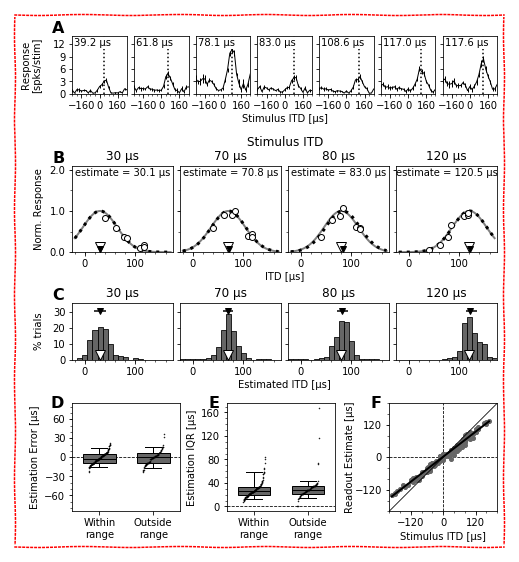

In [47]:
n_units = len(pvdc.exemplary_site.units)
n_stim = len(pvdc.exemplary_site.showcase_stim_itds)

outer_right = 0.1
outer_left = 0.8
outer_top = 0.3
outer_bottom = 0.5
group_width = 5.9 # (1.1 * 5 + 0.1 * 4)
individual_width1 = (group_width - 0.1 * (n_units-1)) / n_units
individual_width2 = (group_width - 0.1 * (n_stim-1)) / n_stim

fig4 = plt.figure(figsize=(
    outer_left + group_width + outer_right,
    outer_top + 0.8 + 1.0 + 1.2 + 0.7 + 0.8 + 0.6 + 1.5 + outer_bottom
))

axs1, axg1 = fig4.add_axes_group_inch(
    1, len(pvdc.exemplary_site.units),
    group_top = outer_top, group_left = outer_left,
    individual_width = individual_width1, individual_height = 0.8,
    wspace = 0.1, hspace = 0.1,
)
figure_4a_itd_tuning_plots(dc = pvdc, axs=axs1, axg=axg1, show_unitname=False)
plt.setp(axs1, xlim=(-240, 240))
plt.setp(axs1, ylim=(0, 14))
for ax in axs1.flatten():
    ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(3))
    ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(160))
    ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(40))
plt.setp(axs1[:,1:], yticklabels=[])
axg1.subplot_indicator('A')
# ax1.yaxis.label.set_fontsize(14)

axs2, axg2 = fig4.add_axes_group_inch(
    1, 4,
    group_top = outer_top + 0.8 + 1.0, group_left = outer_left,
    individual_width = individual_width2, individual_height = 1.2,
    wspace = 0.1, hspace = 0.1,
)
figure_4b_population_response_profile(dc = pvdc, axs = axs2, axg = axg2, bc = 100)
plt.setp(axs2[:,1:], yticklabels=[])
axg2.title.set_fontweight('normal')
axg2.subplot_indicator('B')

axs3, axg3 = fig4.add_axes_group_inch(
    1, 4,
    group_top = outer_top + 0.8 + 1.0 + 1.2 + 0.7, group_left = outer_left,
    individual_width = individual_width2, individual_height = 0.8,
    wspace = 0.1, hspace = 0.1,
)
figure_4c_estimator_histograms(dc = pvdc, axs = axs3, axg = axg3)
plt.setp(axs3[:,1:], yticklabels=[])
axg3.title.set_fontweight('normal')
axg3.set_title('')
# plt.setp(axs3, title='')
axg3.subplot_indicator('C')

ax4 = fig4.add_axes_inch(bottom=outer_bottom, height=1.5, left=outer_left, width=1.5, label='D')
figure_4d_deviation_boxplot(ax = ax4, dc = pvdc, bcs = [100], show_individual_data=True,
                            report_statistics='print',
)
# ax4.set_ylim(bottom=0)
ax4.subplot_indicator(va='center')

ax5 = fig4.add_axes_inch(bottom=outer_bottom, height=1.5, left=outer_left+1.5+0.65, width=1.5, label='E')
figure_4e_estimation_variability_boxplot(ax = ax5, dc = pvdc, bcs = [100], show_individual_data=True)
ax5.yaxis.set_major_locator(mpl.ticker.MultipleLocator(40))
ax5.subplot_indicator(va='center')

ax6 = fig4.add_axes_inch(bottom=outer_bottom, height=1.5, right=outer_right, width=1.5, label='F')
figure_4f_estimation_posterior(ax = ax6, dc = pvdc, bcs = [100])
ax6.set_ylabel('Readout Estimate [µs]')
ax6.set_ylabel(ax6.get_ylabel(), labelpad=0)
ax6.subplot_indicator(va='center')

fig4.savefig(f'{out_dir}/pv_figure_4.pdf')
fig4.savefig(f'{out_dir}/pv_figure_4.png')
fig4.savefig(f'{out_dir}/pv_figure_4.eps')

fig4.outline()
fig4.get_size_inches()

# Figure 5

## Figure 5 - composed

Model | BC =  40 | amp = 1.00 | sd = 43.579 | rmse = 0.512 | R$^2$ = 0.0563
Fit   | BC =  40 | amp = 1.00 | sd = 53.151 | rmse = 0.506 | R$^2$ = 0.0775
Model | BC =  20 | amp = 1.00 | sd = 64.043 | rmse = 0.719 | R$^2$ = 0.00367
Fit   | BC =  20 | amp = 1.00 | sd = 64.995 | rmse = 0.719 | R$^2$ = 0.00371


array([3.3, 7. ])

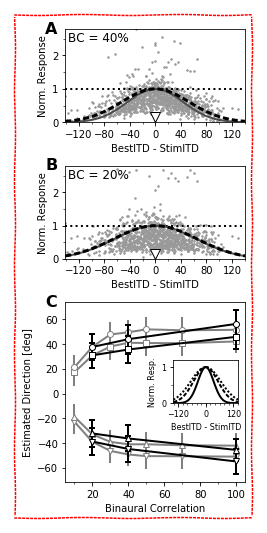

In [48]:
outer_right = 0.1
outer_left = 0.7
outer_top = 0.2
outer_bottom = 0.5
row2_width = 2.5
row1_height = row2_width/25*13
row2_height = row2_width/25*13
row3_height = 2.5
vert_space = 0.6

fig5 = plt.figure(figsize=(outer_left+row2_width+outer_right, outer_top+row1_height+vert_space+row2_height+vert_space+row3_height+outer_bottom))

ax1 = fig5.add_axes_inch(top=outer_top, height=row1_height, left=outer_left, width=row2_width, label='A')
figure_3a_spreading_responses(ax1, pvdc, bc=40, colors=colors, indicate_bc=True, show_optimized=True)
ax1.set_ylim(top=2.8)
ax1.subplot_indicator(va='center')

ax2 = fig5.add_axes_inch(top=outer_top+row1_height+vert_space, height=row1_height, left=outer_left, width=row2_width, label='B')
figure_3a_spreading_responses(ax2, pvdc, bc=20, colors=colors, indicate_bc=True, show_optimized=True)
ax2.set_ylim(top=2.8)
ax2.subplot_indicator(va='center')

ax3 = fig5.add_axes_inch(bottom=outer_bottom, height=2.5, left=outer_left, width=row2_width, label='C')
figure_5c_model_results(ax3, pvdc)
ax3.subplot_indicator(va='center')

ax4 = fig5.add_axes_inch(bottom=outer_bottom+1.1, height=.6, right=outer_right+.1, width=.9, label='D')
figure_5c_spreading_fits(ax4, pvdc)
ax4.tick_params(labelsize=8)
ax4.xaxis.label.set_fontsize(8)
ax4.set_ylabel("Norm. Resp.", fontsize=8)


fig5.savefig(f'{out_dir}/pv_figure_5.pdf')
fig5.savefig(f'{out_dir}/pv_figure_5.png')
fig5.savefig(f'{out_dir}/pv_figure_5.eps')

fig5.outline()
fig5.get_size_inches()

# Figure 6

## Figure 6 - composed

1.1
1.4000000000000001
BC = 100 | n_groups =  110 (within), 66 (outside)
BC = 100 | p = 0.669 ('within' vs. 'outside')
BC = 100 | p = 0.132 ('within' vs. 0)
BC = 100 | p = 0.504 ('outside' vs. 0)
BC = 40 | n_groups =  110 (within), 66 (outside)
BC = 40 | p = 0.0487 ('within' vs. 'outside')
BC = 40 | p = 0.0143 ('within' vs. 0)
BC = 40 | p = 0.871 ('outside' vs. 0)
BC = 20 | n_groups =  110 (within), 66 (outside)
BC = 20 | p = 0.0493 ('within' vs. 'outside')
BC = 20 | p = 0.00491 ('within' vs. 0)
BC = 20 | p = 0.876 ('outside' vs. 0)
iqr | BC = 100 | p = 0.297 ('within' vs. 'outside')
iqr | BC = 40 | p = 0.436 ('within' vs. 'outside')
iqr | BC = 40 vs. 100 | p = 4.89e-28 (within)
iqr | BC = 40 vs. 100 | p = 9.17e-18 (outside)
iqr | BC = 20 | p = 0.248 ('within' vs. 'outside')
iqr | BC = 20 vs. 100 | p = 2.19e-33 (within)
iqr | BC = 20 vs. 100 | p = 2.61e-20 (outside)


(array([6.8, 8.4]), array([17.272, 21.336]))

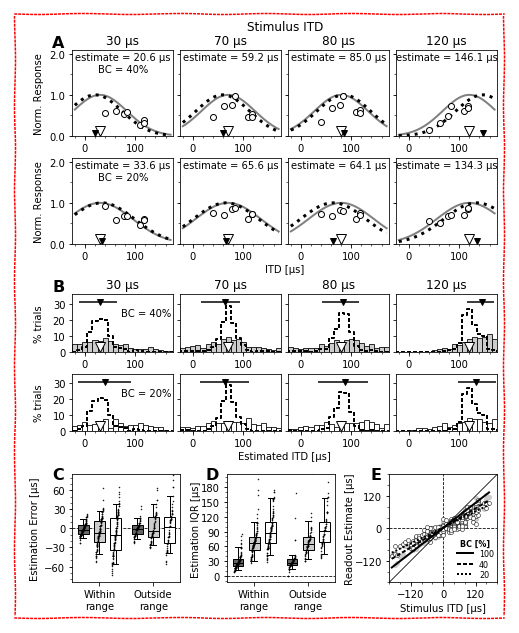

In [49]:
outer_right = 0.1
outer_left = 0.8
outer_top = 0.5
outer_bottom = 0.5
group_width = (1.1 * 5 + 0.1 * 4)
individual_width1 = (group_width - 0.1 * 4) / 5
individual_width2 = (group_width - 0.1 * 3) / 4
print(individual_width1)
print(individual_width2)

fig6 = plt.figure(figsize=(
    outer_left + group_width + outer_right,
    outer_top + 1.2 + 0.3 + 1.2 + 0.7 + 0.8 + 0.3 + 0.8 + 0.6 + 1.5 + outer_bottom
))

axs1, axg1 = fig6.add_axes_group_inch(
    1, 4,
    group_top = outer_top, group_left = outer_left,
    individual_width = individual_width2, individual_height = 1.2,
    wspace = 0.1, hspace = 0.1,
)
figure_4b_population_response_profile(dc = pvdc, axs = axs1, axg = axg1, bc = 40, indicate_bc=True)
plt.setp(axs1[:,1:], yticklabels=[])
axg1.title.set_fontweight('normal')
axg1.set_xlabel('')
for ax in axs1.flatten():
    ax.set_xlabel('')
axg1.subplot_indicator('A')

axs2, axg2 = fig6.add_axes_group_inch(
    1, 4,
    group_top = outer_top + 1.2 + 0.3, group_left = outer_left,
    individual_width = individual_width2, individual_height = 1.2,
    wspace = 0.1, hspace = 0.1,
)
figure_4b_population_response_profile(dc = pvdc, axs = axs2, axg = axg2, bc = 20, indicate_bc=True)
plt.setp(axs2[:,1:], yticklabels=[])
axg2.set_title('')
for ax in axs2.flatten():
    ax.set_title('')

axs3, axg3 = fig6.add_axes_group_inch(
    1, 4,
    group_top = outer_top + 1.2 + 0.3 + 1.2 + 0.7, group_left = outer_left,
    individual_width = individual_width2, individual_height = 0.8,
    wspace = 0.1, hspace = 0.1,
)
figure_4c_estimator_histograms(dc = pvdc, axs = axs3, axg = axg3, bc=40, indicate_bc=True)
plt.setp(axs3[:,1:], yticklabels=[])
axg3.title.set_fontweight('normal')
axg3.set_title('')
axg3.set_xlabel('')
axg3.subplot_indicator('B')

axs4, axg4 = fig6.add_axes_group_inch(
    1, 4,
    group_top = outer_top + 1.2 + 0.3 + 1.2 + 0.7 + 0.8 + 0.3, group_left = outer_left,
    individual_width = individual_width2, individual_height = 0.8,
    wspace = 0.1, hspace = 0.1,
)
figure_4c_estimator_histograms(dc = pvdc, axs = axs4, axg = axg4, bc=20, indicate_bc=True)
plt.setp(axs4[:,1:], yticklabels=[])
axg4.set_title('')
for ax in axs4.flatten():
    ax.set_title('')

    
ax5 = fig6.add_axes_inch(bottom=outer_bottom, height=1.5, left=outer_left, width=1.5, label='C')
figure_4d_deviation_boxplot(ax = ax5, dc = pvdc, bcs = [100,40,20],
                            show_individual_data=True,
                            report_statistics='print')
# ax5.set_ylim(-150,150)
ax5.subplot_indicator(va='center')

ax6 = fig6.add_axes_inch(bottom=outer_bottom, height=1.5, left=outer_left+1.5+0.65, width=1.5, label='D')
figure_4e_estimation_variability_boxplot(ax = ax6, dc = pvdc, bcs = [100,40,20],
                                         show_individual_data=True,
                                         report_statistics='print')
ax6.set_ylim(top=205)
ax6.set_ylabel(ax6.get_ylabel(), labelpad=0)
ax6.subplot_indicator(va='center')

ax7 = fig6.add_axes_inch(bottom=outer_bottom, height=1.5, right=outer_right, width=1.5, label='E')
figure_4f_estimation_posterior(ax = ax7, dc = pvdc, bcs = [40,20], linreg_bcs=[100,40,20])
lhandles, llabels = ax7.get_legend_handles_labels()
lh = ax7.legend(handles=lhandles, labels = [f'{ll}' for ll in llabels], title='BC [%]', title_fontsize=8,
           loc='lower right', fontsize=8, labelspacing=0.2, frameon=False, borderaxespad=0)
lh.get_title().set_fontweight('bold')
ax7.set_ylabel('Readout Estimate [µs]')
ax7.set_ylabel(ax7.get_ylabel(), labelpad=0)
ax7.subplot_indicator(va='center')

fig6.savefig(f'{out_dir}/pv_figure_6.pdf')
fig6.savefig(f'{out_dir}/pv_figure_6.png')
fig6.savefig(f'{out_dir}/pv_figure_6.eps')

fig6.outline()
fig6.get_size_inches(), fig6.get_size_inches() * 2.54

## Quantification text output

Estimation Results from mean response profiles

|  BC |  n  |    0    |    5    |   25    |   50    |   75    |   95    |   100   |  wilcoxon |
| --- | --- | ------- | ------- | ------- | ------- | ------- | ------- | ------- | --------- |
| 100 | 176 |  -37.47 |  -18.28 |   -8.84 |   -1.05 |    6.27 |   17.18 |   36.66 | p = 0.244 |
|  40 | 176 |  -77.47 |  -41.43 |  -17.55 |   -1.22 |   25.12 |   47.83 |   93.03 | p = 0.545 |
|  20 | 176 | -324.65 |  -78.08 |  -39.28 |   -6.55 |   38.32 |   70.88 |  312.58 | p = 0.434 |


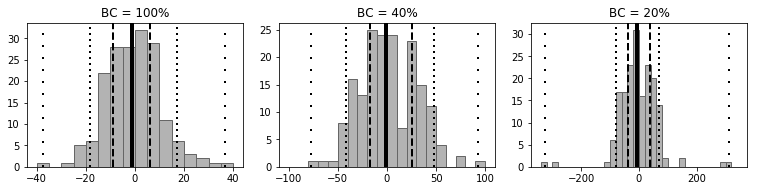

Estimation Results from mean response profiles - Absolute Errors

|  BC |  n  |    0    |   25    |   50    |   75    |   90    |   95    |   100   |
| --- | --- | ------- | ------- | ------- | ------- | ------- | ------- | ------- |
| 100 | 176 |    0.00 |    3.09 |    7.44 |   11.45 |   18.21 |   21.77 |   37.47 |
|  40 | 176 |    0.00 |    9.47 |   22.95 |   35.12 |   44.68 |   50.86 |   93.03 |
|  20 | 176 |    0.06 |   16.54 |   39.21 |   60.53 |   75.42 |   94.69 |  324.65 |


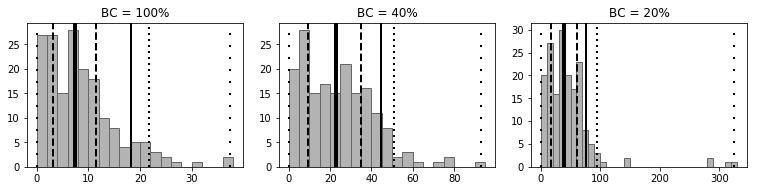

In [50]:
def mean_estimation_test_output(dc = None, bcs = [20, 40, 100],
        qs = None, abs_errors = False,
        hist_plot = True,
    ):
    from statistics.pairedtests import test_notnormal as paired_test_notnormal
    
    if dc is None:
        dc = pvdc
    if not set(bcs).issubset({20,40,100}):
        raise ValueError('Only BC 20,40,100 allowed.')
    bcs = sorted(bcs, reverse=True)
    
    if qs is None:
        if abs_errors:
            qs = [0, 25, 50, 75, 90, 95, 100]
        else:
            qs = [0, 5, 25, 50, 75, 95, 100]

    print('Estimation Results from mean response profiles' + (' - Absolute Errors' if abs_errors else ''))
    print('==============================================' + ('==================' if abs_errors else ''))
    print()
        
    print(("|  BC |  n  |" + len(qs) * " {:^7} |").format(*qs) + ('  wilcoxon |' if not abs_errors else ''))
    print(("| --- | --- |" + len(qs) * " {:-^7} |").format(*(['']*len(qs))) + (' --------- |' if not abs_errors else ''))

    fig, axs, axg = make_figure(1,len(bcs), individual_height_inch=2)

    for kbc, bc in enumerate(bcs):
        print(f"| {bc:3d} |", end='')

        a = np.array([se['delta_itd'] * se['hemisphere_sign'] for se in dc.sites_estimators if se['bc'] == bc])
        print(f" {a.size:3d} |", end='')
        if abs_errors:
            a = np.abs(a)

        if hist_plot:
            ax = axs[0,kbc]
            if abs_errors:
                binwidth = 2 if bc == 100 else (5 if bc == 40 else 10)
                abs_edge = np.ceil(np.abs(a.max()) / binwidth) * binwidth
                bins = np.arange(0, +abs_edge+binwidth, binwidth)
            else:
                binwidth = 5 if bc == 100 else (10 if bc == 40 else 20)
                abs_edge = np.ceil(np.max(np.abs([a.min(), a.max()])) / binwidth) * binwidth
                bins = np.arange(-abs_edge, +abs_edge+binwidth, binwidth)
            ax.hist(a, bins=bins, color='.7', edgecolor='.4')
            ax.set_title(f'BC = {bc}%')

        for q in qs:
            p = np.percentile(a, q)
            print(f" {p:7.2f} |", end='')
            if hist_plot:
                ax.axvline(p, color='k',
                           lw=4 if q == 50 else 2,
                           ls={25: '--', 45: (0,(1,2)), 50: (0,(1,5))}.get(abs(q-50), '-')
                          )
        if abs_errors:
            print()
        else:
            print(" p = {:.3} |".format(paired_test_notnormal(a, 0)))
    plt.show()

mean_estimation_test_output()
mean_estimation_test_output(abs_errors=True)

In [51]:
def estimation_text_output(dc = None, bcs = [20, 40, 100],
        use_site_medians = True,
        report_statistics = True,
        qs = None, abs_errors = False,
        groups = 2,
    ):

    if dc is None:
        dc = pvdc
    if not set(bcs).issubset({20,40,100}):
        raise ValueError('Only BC 20,40,100 allowed.')

    if qs is None:
        if abs_errors:
            qs = [0, 25, 50, 75, 90, 95, 100]
        else:
            qs = [0, 5, 25, 50, 75, 95, 100]

    if groups == 2:
        groups = ['within', 'outside']
    elif groups == 3:
        groups = ['frontal', 'within', 'lateral']
    else:
        if not (isinstance(groups, list) and
            set(groups).issubset({'frontal', 'within', 'lateral', 'outside'})):
            raise ValueError("Groups must be 2, 3 or a list containing"
                             " 'frontal', 'within', 'lateral' and/or 'outside'")
    group_filters = {
        'frontal': lambda x: (x < -1),
        'within': lambda x: (x >= -1) & (x <= +1),
        'lateral': lambda x: (x > +1),
        'outside': lambda x: (x > +1) | (x < -1),
    }

    xx = {}
    yy = {}
    yy_all = {}
    for bc in set(bcs):
        sites_estimators = dc.filter_sites_estimators(bc = bc)
        xx[bc] = np.asarray([se['norm_itd'] for se in sites_estimators])
        if use_site_medians:
            if abs_errors:
                yy[bc] = np.asarray([np.abs(se['delta_itds_median']) for se in sites_estimators])
            else:
                yy[bc] = np.asarray([se['hemisphere_sign'] * se['delta_itds_median'] for se in sites_estimators])
        else:
            if abs_errors:
                yy_all[bc] = np.asarray([np.abs(se['delta_itds']) for se in sites_estimators], dtype='object')
            else:
                yy_all[bc] = np.asarray([se['hemisphere_sign'] * se['delta_itds'] for se in sites_estimators], dtype='object')
    
    for bc in sorted(bcs, reverse=True):
        print(f'\nBC = {bc:3}%\n=========')
        if use_site_medians:
            group_vals = [yy[bc][group_filters[g](xx[bc])] for g in groups]
        else:
            group_vals = [np.concatenate(yy_all[bc][group_filters[g](xx[bc])]) for g in groups]
        group_vals_sorted = [np.sort(vals) for vals in group_vals]

        print(f"n_groups = ", ', '.join([f"{len(gv)} ({g})" for g, gv in zip(groups, group_vals)]))
        
        for g, gv in zip(groups, group_vals):
            print("{g:>8} | p25 = {p25:.2f} | median = {median:.2f} | p75 = {p75:.2f}".format(
                g = g,
                p25 = np.percentile(gv, 25),
                median = np.median(gv),
                p75 = np.percentile(gv, 75),
            ))
        
        print('\nStats:')
        if report_statistics and len(groups) == 2:
            from statistics.unpairedtests import test_notnormal as unpaired_test_notnormal
            from statistics.pairedtests import test_notnormal as paired_test_notnormal
            p = unpaired_test_notnormal(group_vals[0], group_vals[1])
            print(f"p = {p:.3} ('within' vs. 'outside')")
            for g, gv in zip(groups, group_vals):
                p = paired_test_notnormal(gv, 0)
                print(f"p = {p:.3} ('{g}' vs. 0)")

        elif report_statistics:
            from statistics.pairedtests import test_notnormal as paired_test_notnormal
            print("Statistics:")
            for g, gv in zip(groups, group_vals):
                p = paired_test_notnormal(gv, 0)
                print(g, p)
        foo[bc] = group_vals

        print(("|  group  |  n  |" + len(qs) * " {:^7} |").format(*qs))
        print(("| ------- | --- |" + len(qs) * " {:-^7} |").format(*(['']*len(qs))))
        for g, gv in zip(groups, group_vals):
            print(f"| {g:7} |", end='')
            print(f" {gv.size:3d} |", end='')
            for q in qs:
                    p = np.percentile(gv, q)
                    print(f" {p:7.2f} |", end='')
            print()
        
foo = {}
print('+-----------------+')
print('|  SIGNED ERRORS  |')
print('+-----------------+')
estimation_text_output(pvdc)
print()
print('+-----------------+')
print('| ABSOLUTE ERRORS |')
print('+-----------------+')
estimation_text_output(pvdc, abs_errors=True)

+-----------------+
|  SIGNED ERRORS  |
+-----------------+

BC = 100%
n_groups =  110 (within), 66 (outside)
  within | p25 = -8.96 | median = -1.91 | p75 = 5.11
 outside | p25 = -9.31 | median = -0.22 | p75 = 6.05

Stats:
p = 0.368 ('within' vs. 'outside')
p = 0.132 ('within' vs. 0)
p = 0.504 ('outside' vs. 0)
|  group  |  n  |    0    |    5    |   25    |   50    |   75    |   95    |   100   |
| ------- | --- | ------- | ------- | ------- | ------- | ------- | ------- | ------- |
| within  | 110 |  -22.75 |  -14.85 |   -8.96 |   -1.91 |    5.11 |   16.58 |   23.32 |
| outside |  66 |  -22.87 |  -18.83 |   -9.31 |   -0.22 |    6.05 |   16.74 |   35.95 |

BC =  40%
n_groups =  110 (within), 66 (outside)
  within | p25 = -21.35 | median = -6.57 | p75 = 12.39
 outside | p25 = -13.12 | median = -3.95 | p75 = 17.77

Stats:
p = 0.0487 ('within' vs. 'outside')
p = 0.0143 ('within' vs. 0)
p = 0.871 ('outside' vs. 0)
|  group  |  n  |    0    |    5    |   25    |   50    |   75    |   95  

In [52]:
def estimation_variability_text_output(dc = None, bcs = [20, 40, 100],
        use_site_medians = True,
        report_statistics = True,
        qs = None,
        groups = 2,
        error_type = 'iqr'
    ):

    if dc is None:
        dc = pvdc
    if not set(bcs).issubset({20,40,100}):
        raise ValueError('Only BC 20,40,100 allowed.')

    if qs is None:
        qs = [0, 25, 50, 75, 90, 95, 100]

    if error_type == 'iqr':
        error_key = 'itds_iqr'
    elif error_type == 'var':
        error_key = 'estimation_var'
    elif error_type == 'sem':
        error_key = 'estimation_sem'
    elif error_type == 'std':
        error_key = 'estimation_std'
    elif error_type == 'rmse':
        error_key = 'estimation_err'
    else:
        raise ValueError(f"Unknown error type '{error_type}', try 'iqr', 'var' or 'sem'")

    if groups == 2:
        groups = ['within', 'outside']
    elif groups == 3:
        groups = ['frontal', 'within', 'lateral']
    else:
        if not (isinstance(groups, list) and
            set(groups).issubset({'frontal', 'within', 'lateral', 'outside', 'all'})):
            raise ValueError("Groups must be 2, 3 or a list containing"
                             " 'frontal', 'within', 'lateral' and/or 'outside'")
    group_filters = {
        'frontal': lambda x: (x < -1),
        'within': lambda x: (x >= -1) & (x <= +1),
        'lateral': lambda x: (x > +1),
        'outside': lambda x: (x > +1) | (x < -1),
        'all': lambda x: np.ones_like(x, dtype=bool),
    }

    xx = {}
    yy = {}
    yy_all = {}
    for bc in set(bcs):
        sites_estimators = dc.filter_sites_estimators(bc = bc)
        xx[bc] = np.asarray([se['norm_itd'] for se in sites_estimators])
        yy[bc] = np.asarray([se[error_key] for se in sites_estimators])
    
    for bc in sorted(bcs, reverse=True):
        print(f'\nBC = {bc:3}%\n=========')
        group_vals = [yy[bc][group_filters[g](xx[bc])] for g in groups]
        group_vals_sorted = [np.sort(vals) for vals in group_vals]

        print(f"n_groups = ", ', '.join([f"{len(gv)} ({g})" for g, gv in zip(groups, group_vals)]))
        
        for g, gv in zip(groups, group_vals):
            print("{g:>8} | p25 = {p25:.2f} | median = {median:.2f} | p75 = {p75:.2f}".format(
                g = g,
                p25 = np.percentile(gv, 25),
                median = np.median(gv),
                p75 = np.percentile(gv, 75),
            ))
        
        print('\nStats:')
        if report_statistics and 'within' in groups and 'outside' in groups:
            from statistics.unpairedtests import diff_test as unpaired_diff_test
            from statistics.pairedtests import test_notnormal as paired_test_notnormal
            p = unpaired_diff_test(group_vals[groups.index('within')], group_vals[groups.index('outside')])
            print(f"p = {p:.3} ('within' vs. 'outside')")
            for g, gv in zip(groups, group_vals):
                p = paired_test_notnormal(gv, 0)
                print(f"p = {p:.3} ('{g}' vs. 0)")

        elif report_statistics:
            from statistics.pairedtests import test_notnormal as paired_test_notnormal
            print("Statistics:")
            for g, gv in zip(groups, group_vals):
                p = paired_test_notnormal(gv, 0)
                print(g, p)
        foo[bc] = group_vals

        print(("|  group  |  n  |" + len(qs) * " {:^7} |").format(*qs))
        print(("| ------- | --- |" + len(qs) * " {:-^7} |").format(*(['']*len(qs))))
        for g, gv in zip(groups, group_vals):
            print(f"| {g:7} |", end='')
            print(f" {gv.size:3d} |", end='')
            for q in qs:
                    p = np.percentile(gv, q)
                    print(f" {p:7.2f} |", end='')
            print()
        
foo = {}
estimation_variability_text_output(pvdc, groups=['within', 'outside', 'all'])



BC = 100%
n_groups =  110 (within), 66 (outside), 176 (all)
  within | p25 = 20.16 | median = 26.02 | p75 = 33.78
 outside | p25 = 21.80 | median = 27.44 | p75 = 34.95
     all | p25 = 21.27 | median = 26.98 | p75 = 34.74

Stats:
p = 0.297 ('within' vs. 'outside')
p = 8.75e-20 ('within' vs. 0)
p = 3.53e-12 ('outside' vs. 0)
p = 2.64e-30 ('all' vs. 0)
|  group  |  n  |    0    |   25    |   50    |   75    |   90    |   95    |   100   |
| ------- | --- | ------- | ------- | ------- | ------- | ------- | ------- | ------- |
| within  | 110 |    8.24 |   20.16 |   26.02 |   33.78 |   47.83 |   58.36 |   84.93 |
| outside |  66 |    0.00 |   21.80 |   27.44 |   34.95 |   39.13 |   65.09 |  167.04 |
| all     | 176 |    0.00 |   21.27 |   26.98 |   34.74 |   42.88 |   60.05 |  167.04 |

BC =  40%
n_groups =  110 (within), 66 (outside), 176 (all)
  within | p25 = 53.33 | median = 67.55 | p75 = 79.43
 outside | p25 = 52.73 | median = 65.27 | p75 = 79.36
     all | p25 = 52.85 | median = 67.

# Additional analysis for revision

In [53]:
from sidepeak_response3 import side_peak_relation3 as sp_relation

bc = 100

sp_data = []

for s in pvdc.itd_sites:
    for u in s.units.values():
        resp = u.responses(('itd_bc', 0))
        resp_mean = resp.groupby(['bc', 'itd']).mean()
        resp_itd = resp_mean.loc[bc].index.get_level_values('itd').values
        resp_val = resp_mean.loc[bc, u.name].values
        try:
            d = sp_relation(resp_itd, resp_val)
            d.update({'unit': u})
            sp_data.append(d)
        except:
            print(u, resp_itd, resp_val)
            fig, ax = plt.subplots()
            ax.plot(resp_itd, resp_val)
            display(fig)
            raise

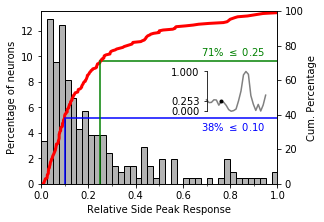

In [54]:
bc = 100


sps_indexes = pvdc.sps_indexes
fig, ax = plt.subplots(1,1, figsize=(4.5,3), gridspec_kw=dict(left=0.12, right=0.85, top=0.95, bottom=0.15))
sp_counts, sp_bins = np.histogram(sps_indexes, bins=np.linspace(0,1,41))
sp_counts_rel = sp_counts / np.sum(sp_counts)
ax.bar(sp_bins[:-1], sp_counts_rel * 100, width=np.diff(sp_bins[:2]), align='edge', color='.7', edgecolor='k')


# ax.axvline(np.percentile(sps_indexes, 75), label=f"75th-percentile ({np.percentile(sps_indexes, 75):.3f})", ls='-', color='k')
# ax.axvline(np.percentile(sps_indexes, 50), label=f"50th-percentile ({np.percentile(sps_indexes, 50):.3f})", ls='--', color='k')
# ax.axvline(np.percentile(sps_indexes, 25), label=f"25th-percentile ({np.percentile(sps_indexes, 25):.3f})", ls=':', color='k')

ax.set_xlim(0, 1)
ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.1))

ax2 = ax.twinx()
ax2.set_ylim(0, 100)

val_025 = np.searchsorted(np.sort(sps_indexes), 0.25) / sps_indexes.size
ax2.axvline(0.25, ymax = val_025, label=f"{val_025:.1%} $\leq$ 0.25", ls='-', color='g', zorder=100)
ax2.axhline(val_025 * 100, xmin = 0.25, ls='-', color='g')
ax2.text(0.95, val_025 * 100 + 2, f"{val_025:.0%} $\leq$ 0.25", color='g', ha='right', va='bottom')

val_010 = np.searchsorted(np.sort(sps_indexes), 0.10) / sps_indexes.size
ax2.axvline(0.10, ymax = val_010, label=f"{val_010:.1%} $\leq$ 0.10", ls='-', color='b', zorder=100)
ax2.axhline(val_010 * 100, xmin = 0.10, ls='-', color='b')
ax2.text(0.95, val_010 * 100 - 2, f"{val_010:.0%} $\leq$ 0.10", color='b', ha='right', va='top')

ax2.plot(np.sort(sps_indexes), np.arange(sps_indexes.size) / sps_indexes.size * 100, color='r', lw=3)

ax.set_xlabel("Relative Side Peak Response")
ax.set_ylabel("Percentage of neurons")
ax2.set_ylabel("Cum. Percentage")
#ax2.legend(loc='center right', frameon=False)

# ITD-tuning curve of exemplary unit 3a:
d = pvdc.exemplary_itd_resp.loc[100, '3a'].reset_index()
x = np.linspace(0,1,d.shape[0])
y = (d['mean'] - d['mean'].min()).values
y /= y.max()

spr = side_peak_relation(x,y)

ax3 = fig.add_axes([0, 0, 1, 1], label='inset b')
ax3.set_axes_locator(InsetPosition(ax, [0.7, 0.42, 0.25, 0.23]))
ax3.set_xlim(0,1)
ax3.set_ylim(0,1)
ax3.set_xticks([])
ax3.set_yticks([0,spr['side_Y'],1])
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.spines['bottom'].set_visible(False)

ax3.plot(x,y, c='.5', clip_on=False)
#ax3.plot([0, spr['side_X']], [spr['side_Y'],spr['side_Y']], c='r')
ax3.plot([spr['side_X']], [spr['side_Y']], '.k')

fig.savefig(f'{out_dir}/side-peak-responses_bc{bc}.png', facecolor='None')